## GATConv  - Parallel

Rotor output - Ct/Cq 

In [1]:
import os
import pandas as pd
import numpy as np
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from typing import Optional
from torch.utils.data import Dataset

import joblib
from sklearn.preprocessing import MinMaxScaler

from scipy.fftpack import fft, ifft
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [2]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
sys.path.append('/mnt/e/eVTOL_model/eVTOL-VehicleModel/src')


# Import necessary functions
from utility_functions import downsample_to_35
from utility_functions import organize_data

# Import all the models
from af_escnn_cl import ESCNN_Cl
from af_escnn_cd import ESCNN_Cd

from af_rbf_cl import RBFLayer_cl, RBFNet_cl
from af_rbf_cd import RBFLayer_cd, RBFNet_cd

### Initialize Airfoil Models

In [4]:
# Initialize airfoil models
root_airfoilModelsTrained = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/airfoil/'
# root_scalers = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/scalers/'

# Load the model weights
af_model_ESCNN_Cl = ESCNN_Cl()
af_model_ESCNN_Cl.load_state_dict(torch.load(root_airfoilModelsTrained + '2024-11-18_model_Cl_ESCNN_lr1e-05_e1500_rbf170_convL4.pth'))
af_model_ESCNN_Cl = af_model_ESCNN_Cl.to(device)
af_model_ESCNN_Cl.eval()

# Load the model weights
af_model_ESCNN_Cd = ESCNN_Cd()
af_model_ESCNN_Cd.load_state_dict(torch.load(root_airfoilModelsTrained + '2024-11-18_model_Cd_ESCNN_lr5e-05_e250_convL3.pth'))
af_model_ESCNN_Cd = af_model_ESCNN_Cd.to(device)
af_model_ESCNN_Cd.eval()

input_size = 140
output_size = 4
num_rbf_units = 4

kmeans_center_cl = torch.load(root_airfoilModelsTrained + '2024-11-19_airfoil_model_Cl_ESCNN_RBF_lr0.06_epoch200_rbfUnits4_RBFcenters.pth')
kmeans_center_cd = torch.load(root_airfoilModelsTrained + '2024-11-19_airfoil_model_Cd_ESCNN_RBF_lr0.025_epoch100_rbfUnits4_RBFcenters.pth')


class airfoilModel_cl(RBFNet_cl):
    def __init__(self):
        super(airfoilModel_cl, self).__init__(input_size, num_rbf_units, output_size, kmeans_center_cl)


class airfoilModel_cd(RBFNet_cd):
    def __init__(self):
        super(airfoilModel_cd, self).__init__(input_size, num_rbf_units, output_size, kmeans_center_cd)


# Initialize the model
airfoil_cl = airfoilModel_cl()
airfoil_cl.load_state_dict(torch.load(root_airfoilModelsTrained + '2024-11-19_airfoil_model_Cl_ESCNN_RBF_lr0.06_epoch200_rbfUnits4.pth'))

airfoil_cd = airfoilModel_cd()
airfoil_cd.load_state_dict(torch.load(root_airfoilModelsTrained + '2024-11-19_airfoil_model_Cd_ESCNN_RBF_lr0.025_epoch100_rbfUnits4.pth'))

airfoil_cl = airfoil_cl.to(device)
airfoil_cd = airfoil_cd.to(device)

airfoil_cl.eval()
airfoil_cd.eval()



/tmp/ipykernel_1176/829076333.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  af_model_ESCNN_Cl.load_state_dict(torch.load(root_airfoilModelsTrained + '2024-11-18_model_

airfoilModel_cd(
  (rbf): RBFLayer_cd()
  (fc): Linear(in_features=4, out_features=4, bias=True)
)

## Load Wing Data

In [5]:
from create_wing_dataset import WingDataset, subdir_condition_wing   # Make sure to reload the create wing dataset module manually after changes

# root_dir_wing = '/mnt/e/Course_Materials/ROM/wing_model/FLOWUnsteady_simulations/eMO_dataset_train'
root_dir_wing = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/FLOWUnsteady_simulations/aircraft_data/training_data'

# Canard dataset
dataset_canard = WingDataset(root_dir_wing, 
                                af_model_ESCNN_Cl=af_model_ESCNN_Cl, 
                                af_model_ESCNN_Cd=af_model_ESCNN_Cd,
                                airfoil_cl=airfoil_cl, 
                                airfoil_cd=airfoil_cd, 
                                device=device,
                                wing_name = 'Canard',     # select 'wing_main' or 'Canard'  
                                subdir_condition=subdir_condition_wing)

inputs_canard, outputs_canard = dataset_canard[0:]

input_tensor_canard = inputs_canard
input_tensor_canard = inputs_canard.squeeze(1)  # Reshaping
print("Input shape (Canard dataset):", input_tensor_canard.shape)

output_tensor_canard = outputs_canard.squeeze(1)
print("Output shape (Canard dataset):",output_tensor_canard.shape) 

# Wing dataset
dataset_wing = WingDataset(root_dir_wing, 
                            af_model_ESCNN_Cl=af_model_ESCNN_Cl, 
                            af_model_ESCNN_Cd=af_model_ESCNN_Cd,
                            airfoil_cl=airfoil_cl, 
                            airfoil_cd=airfoil_cd, 
                            device=device,
                            wing_name = 'wing_main',     # select 'wing_main' or 'Canard'  
                            subdir_condition=subdir_condition_wing)

inputs_wing, outputs_wing = dataset_wing[0:]

input_tensor_wing = inputs_wing
input_tensor_wing = inputs_wing.squeeze(1)  # Reshaping
print("Input shape (Wing dataset):", input_tensor_wing.shape)

output_tensor_wing = outputs_wing.squeeze(1)
print("Output shape (Wing dataset):",output_tensor_wing.shape) 




create_wing_dataset module loaded


/mnt/e/eVTOL_model/eVTOL-VehicleModel/src/create_wing_dataset.py:376: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)


Input shape (Canard dataset): torch.Size([39, 277, 10])
Output shape (Canard dataset): torch.Size([39, 277, 2])
Input shape (Wing dataset): torch.Size([39, 277, 10])
Output shape (Wing dataset): torch.Size([39, 277, 2])


## Load Rotor Data

In [6]:
from create_rotor_dataset import PropellerDataset, subdir_condition_rotor

# Root directory where simulation subdirectories are stored
# root_dir_rotor = '/mnt/e/Course_Materials/ROM/rotor_solver/FLOWUnsteady_simulations/train_data'
root_dir_rotor = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/FLOWUnsteady_simulations/aircraft_data/training_data'

# dataset - Rotor L1
dataset_rotor_L1 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'L1',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rL1, outputs_rL1 = dataset_rotor_L1[0:]


input_tensor_rL1 = inputs_rL1.squeeze(1)  # Reshaping
print("Input shape (rotor - L1):", input_tensor_rL1.shape) 

output_tensor_rL1 = outputs_rL1.squeeze(1)
print("Output shape (rotor - L1):",output_tensor_rL1.shape) 


# dataset - Rotor L2
dataset_rotor_L2 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'L2',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rL2, outputs_rL2 = dataset_rotor_L2[0:]


input_tensor_rL2 = inputs_rL2.squeeze(1)  # Reshaping
print("Input shape (rotor - L2):", input_tensor_rL2.shape) 

output_tensor_rL2 = outputs_rL2.squeeze(1)
print("Output shape (rotor - L2):",output_tensor_rL2.shape) 

# dataset - Rotor L3
dataset_rotor_L3 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'L3',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rL3, outputs_rL3 = dataset_rotor_L3[0:]


input_tensor_rL3 = inputs_rL3.squeeze(1)  # Reshaping
print("Input shape (rotor - L3):", input_tensor_rL3.shape) 

output_tensor_rL3 = outputs_rL3.squeeze(1)
print("Output shape (rotor - L3):",output_tensor_rL3.shape) 

# dataset - Rotor L4
dataset_rotor_L4 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'L4',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rL4, outputs_rL4 = dataset_rotor_L4[0:]


input_tensor_rL4 = inputs_rL4.squeeze(1)  # Reshaping
print("Input shape (rotor - L4):", input_tensor_rL4.shape) 

output_tensor_rL4 = outputs_rL4.squeeze(1)
print("Output shape (rotor - L4):",output_tensor_rL4.shape) 

Input shape (rotor - L1): torch.Size([39, 280, 10])
Output shape (rotor - L1): torch.Size([39, 280, 2])
Input shape (rotor - L2): torch.Size([39, 280, 10])
Output shape (rotor - L2): torch.Size([39, 280, 2])
Input shape (rotor - L3): torch.Size([39, 280, 10])
Output shape (rotor - L3): torch.Size([39, 280, 2])
Input shape (rotor - L4): torch.Size([39, 280, 10])
Output shape (rotor - L4): torch.Size([39, 280, 2])


In [7]:
# dataset - Rotor R1
dataset_rotor_R1 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'R1',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rR1, outputs_rR1 = dataset_rotor_R1[0:]


input_tensor_rR1 = inputs_rR1.squeeze(1)  # Reshaping
print("Input shape (rotor - R1):", input_tensor_rR1.shape) 

output_tensor_rR1 = outputs_rR1.squeeze(1)
print("Output shape (rotor - R1):",output_tensor_rR1.shape) 


# dataset - Rotor R2
dataset_rotor_R2 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'R2',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rR2, outputs_rR2 = dataset_rotor_R2[0:]


input_tensor_rR2 = inputs_rR2.squeeze(1)  # Reshaping
print("Input shape (rotor - R2):", input_tensor_rR2.shape) 

output_tensor_rR2 = outputs_rR2.squeeze(1)
print("Output shape (rotor - R2):",output_tensor_rR2.shape) 

# dataset - Rotor R3
dataset_rotor_R3 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'R3',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rR3, outputs_rR3 = dataset_rotor_R3[0:]


input_tensor_rR3 = inputs_rR3.squeeze(1)  # Reshaping
print("Input shape (rotor - R3):", input_tensor_rR3.shape) 

output_tensor_rR3 = outputs_rR3.squeeze(1)
print("Output shape (rotor - R3):",output_tensor_rR3.shape) 

# dataset - Rotor R4
dataset_rotor_R4 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'R4',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rR4, outputs_rR4 = dataset_rotor_R4[0:]


input_tensor_rR4 = inputs_rR4.squeeze(1)  # Reshaping
print("Input shape (rotor - R4):", input_tensor_rR4.shape) 

output_tensor_rR4 = outputs_rR4.squeeze(1)
print("Output shape (rotor - R4):",output_tensor_rR4.shape) 

Input shape (rotor - R1): torch.Size([39, 280, 10])
Output shape (rotor - R1): torch.Size([39, 280, 2])
Input shape (rotor - R2): torch.Size([39, 280, 10])
Output shape (rotor - R2): torch.Size([39, 280, 2])
Input shape (rotor - R3): torch.Size([39, 280, 10])
Output shape (rotor - R3): torch.Size([39, 280, 2])
Input shape (rotor - R4): torch.Size([39, 280, 10])
Output shape (rotor - R4): torch.Size([39, 280, 2])


## Load Wing Model and Initialize

In [8]:
from wing_static import LSTMNet_static

# Static Model
input_size_wing_stat = 10           # Number of input features
hidden_size_wing_stat = 50          # Hidden LSTM cells
output_size_wing_stat = 2           # Number of output features
num_layers_wing_stat = 3            # Number of LSTM layers

class WingModel_static(LSTMNet_static):
    def __init__(self):
        super(WingModel_static, self).__init__(input_size_wing_stat, hidden_size_wing_stat, output_size_wing_stat, num_layers_wing_stat)

# Initialize the model

root_wingModelsTrained = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/wing/'
root_wingScalersTrained = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/scalers/wing/'

wing_model_static = WingModel_static()
wing_model_static.load_state_dict(torch.load(root_wingModelsTrained+'2024-11-19_LSTM_eMO_wingModel_static_lr0.002_e1200_nL3_numNN50.pth'))
wing_model_static = wing_model_static.to(device)
wing_model_static.eval()

# Load the scaler
input_scaler_wing_stat = joblib.load(root_wingScalersTrained+'2024-11-19_LSTM_eMO_wingModel_static_ipScaler_lr0.002_e1200_nL3_numNN50.pkl')
output_scaler_wing_stat = joblib.load(root_wingScalersTrained+'2024-11-19_LSTM_eMO_wingModel_static_opScaler_lr0.002_e1200_nL3_numNN50.pkl')

/tmp/ipykernel_1176/1761514772.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wing_model_static.load_state_dict(torch.load(root_wingModelsTrained+'2024-11-19_LSTM_eMO_

## Load Rotor Model and Initialize

In [9]:
from rotor_model import LSTMNet_rotor

input_size = 10
hidden_size = 100
output_size = 2
num_layers = 4

class PropModel(LSTMNet_rotor):
    def __init__(self):
        super(PropModel, self).__init__(input_size, hidden_size, output_size, num_layers)

root_rotorModelsTrained = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/rotor/'
root_rotorScalersTrained = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/scalers/rotor/'

# Initialize the model
# prop_model = PropModel()
# # /mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/rotor/2025-01-30_modified_H26FpropModel_retrained_lr0.0002_e1500_nL4_numNN100.pth
# # prop_model.load_state_dict(torch.load(root_rotorModelsTrained+'2024-10-04_propModel_lr0.005_e1500_nL2_numNN50.pth'))
# prop_model.load_state_dict(torch.load(root_rotorModelsTrained+'2025-01-30_modified_H26FpropModel_retrained_lr0.0002_e1500_nL4_numNN100.pth'))
# prop_model = prop_model.to(device)
# prop_model.eval()

# Load the scaler
# input_scaler_rotor = joblib.load(root_rotorScalersTrained+'2024-10-04_ipScaler_lr0.005_e1500_nL2_numNN50.pkl')
# output_scaler_rotor = joblib.load(root_rotorScalersTrained+'2024-10-04_opScaler_lr0.005_e1500_nL2_numNN50.pkl')

# input_scaler_rotor = joblib.load(root_rotorScalersTrained+'2025-01-30_modified_H26F_ipScaler_lr0.001_e2500_nL4_numNN100.pkl')
# output_scaler_rotor = joblib.load(root_rotorScalersTrained+'2025-01-30_modified_H26F_opScaler_lr0.001_e2500_nL4_numNN100.pkl')

rotor1_model = PropModel()
rotor2_model = PropModel()
rotor3_model = PropModel()
rotor4_model = PropModel()

rotor1_model.load_state_dict(torch.load(root_rotorModelsTrained+'2025-02-05_H26FpropModel_rotor1_lr0.0002_e2500_nL4_numNN100.pth'))
rotor2_model.load_state_dict(torch.load(root_rotorModelsTrained+'2025-02-05_H26FpropModel_rotor2_lr0.0002_e2500_nL4_numNN100.pth'))
rotor3_model.load_state_dict(torch.load(root_rotorModelsTrained+'2025-02-05_H26FpropModel_rotor3_lr0.0002_e2500_nL4_numNN100.pth'))
rotor4_model.load_state_dict(torch.load(root_rotorModelsTrained+'2025-02-05_H26FpropModel_rotor4_lr0.0002_e2500_nL4_numNN100.pth'))


rotor1_model = rotor1_model.to(device)
rotor2_model = rotor2_model.to(device)
rotor3_model = rotor3_model.to(device)
rotor4_model = rotor4_model.to(device)

# 2025-02-05_H26F_rotor4_opScaler_lr0.0002_e2500_nL4_numNN100.pkl
input_scaler_rotor1 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor1_ipScaler_lr0.0002_e2500_nL4_numNN100.pkl')
output_scaler_rotor1 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor1_opScaler_lr0.0002_e2500_nL4_numNN100.pkl')

input_scaler_rotor2 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor2_ipScaler_lr0.0002_e2500_nL4_numNN100.pkl')
output_scaler_rotor2 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor2_opScaler_lr0.0002_e2500_nL4_numNN100.pkl')

input_scaler_rotor3 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor3_ipScaler_lr0.0002_e2500_nL4_numNN100.pkl')
output_scaler_rotor3 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor3_opScaler_lr0.0002_e2500_nL4_numNN100.pkl')

input_scaler_rotor4 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor4_ipScaler_lr0.0002_e2500_nL4_numNN100.pkl')
output_scaler_rotor4 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor4_opScaler_lr0.0002_e2500_nL4_numNN100.pkl')

/tmp/ipykernel_1176/3285829364.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rotor1_model.load_state_dict(torch.load(root_rotorModelsTrained+'2025-02-05_H26FpropModel

In [10]:
from scipy.interpolate import interp1d
import numpy as np

def align_timesteps(data, target_length):
    original_length = data.shape[1]
    x = np.linspace(0, 1, original_length)
    x_new = np.linspace(0, 1, target_length)
    interpolator = interp1d(x, data, axis=1, kind='linear')
    return interpolator(x_new)


In [11]:
class AircraftDataset(Dataset):
    def __init__(self, wing_dataset,
                       canard_dataset, 
                       propeller_L1_dataset, 
                       propeller_L2_dataset,
                       propeller_L3_dataset, 
                       propeller_L4_dataset, 
                       propeller_R1_dataset, 
                       propeller_R2_dataset,
                       propeller_R3_dataset, 
                       propeller_R4_dataset,
                       wing_ip_scaler, wing_op_scaler,
                       rotor1_ip_scaler, rotor1_op_scaler,
                       rotor2_ip_scaler, rotor2_op_scaler,
                       rotor3_ip_scaler, rotor3_op_scaler,
                       rotor4_ip_scaler, rotor4_op_scaler,
                       additional_data=None):
        super().__init__()
        self.wing_dataset = wing_dataset
        self.canard_dataset = canard_dataset
        self.propeller_dataset_L1 = propeller_L1_dataset
        self.propeller_dataset_L2 = propeller_L2_dataset
        self.propeller_dataset_L3 = propeller_L3_dataset
        self.propeller_dataset_L4 = propeller_L4_dataset
        self.propeller_dataset_R1 = propeller_R1_dataset
        self.propeller_dataset_R2 = propeller_R2_dataset
        self.propeller_dataset_R3 = propeller_R3_dataset
        self.propeller_dataset_R4 = propeller_R4_dataset
        
        self.additional_data = additional_data or {}
        self.wing_ip_scaler = wing_ip_scaler
        self.wing_op_scaler = wing_op_scaler
        self.rotor1_ip_scaler = rotor1_ip_scaler
        self.rotor1_op_scaler = rotor1_op_scaler
        self.rotor2_ip_scaler = rotor2_ip_scaler
        self.rotor2_op_scaler = rotor2_op_scaler
        self.rotor3_ip_scaler = rotor3_ip_scaler
        self.rotor3_op_scaler = rotor3_op_scaler
        self.rotor4_ip_scaler = rotor4_ip_scaler
        self.rotor4_op_scaler = rotor4_op_scaler

        # Constants
        k = 0.1301
        self.constants = {
            # Coordinates of the wing, canars and rotors

            "wing": torch.tensor([4.505 * k, 0.0, -0.2 * k], dtype=torch.float32),
            "canard": torch.tensor([1.14 * k, 0.0, 0.35 * k], dtype=torch.float32),
            "rotor_L1": torch.tensor([0.36 * k, -3.842 * k, 0.5 * k], dtype=torch.float32),
            "rotor_L2": torch.tensor([2.28 * k, -3.842 * k, 0.5 * k], dtype=torch.float32),
            "rotor_L3": torch.tensor([4.2 * k, -3.842 * k, 0.5 * k], dtype=torch.float32),
            "rotor_L4": torch.tensor([6.54 * k, -3.842 * k, 0.5 * k], dtype=torch.float32),
            "rotor_R1": torch.tensor([0.36 * k, 3.842 * k, 0.5 * k], dtype=torch.float32),
            "rotor_R2": torch.tensor([2.28 * k, 3.842 * k, 0.5 * k], dtype=torch.float32),
            "rotor_R3": torch.tensor([4.2 * k, 3.842 * k, 0.5 * k], dtype=torch.float32),
            "rotor_R4": torch.tensor([6.54 * k, 3.842 * k, 0.5 * k], dtype=torch.float32)

        }

        # Initialize data storage
        self.data = {
            "time_varying_inputs": None,
            "constant_inputs": None,
            "node_data": {},  # Store node-specific time-varying data
        }
        self.targets = None

        # Combine datasets
        self._combine_data()

    def _combine_data(self):
        # Load wing and rotor datasets

        # Wing dataset
        inputs_wing, target_wing = self.wing_dataset[0:]
        inputs_wing = inputs_wing.squeeze(1)
        target_wing = target_wing.squeeze(1)
        # Canard dataset
        inputs_canard, target_canard = self.canard_dataset[0:]
        inputs_canard = inputs_canard.squeeze(1)
        target_canard = target_canard.squeeze(1)
        # Rotor - L1 dataset
        inputs_rotor_L1, target_rotor_L1 = self.propeller_dataset_L1[0:]
        inputs_rotor_L1 = inputs_rotor_L1.squeeze(1)
        target_rotor_L1 = target_rotor_L1.squeeze(1)
        # Rotor - L2 dataset
        inputs_rotor_L2, target_rotor_L2 = self.propeller_dataset_L2[0:]
        inputs_rotor_L2 = inputs_rotor_L2.squeeze(1)
        target_rotor_L2 = target_rotor_L2.squeeze(1)
        # Rotor - L3 dataset
        inputs_rotor_L3, target_rotor_L3 = self.propeller_dataset_L3[0:]    
        inputs_rotor_L3 = inputs_rotor_L3.squeeze(1)
        target_rotor_L3 = target_rotor_L3.squeeze(1)
        # Rotor - L4 dataset
        inputs_rotor_L4, target_rotor_L4 = self.propeller_dataset_L4[0:]
        inputs_rotor_L4 = inputs_rotor_L4.squeeze(1)
        target_rotor_L4 = target_rotor_L4.squeeze(1)

        # Rotor - R1 dataset
        inputs_rotor_R1, target_rotor_R1 = self.propeller_dataset_R1[0:]
        inputs_rotor_R1 = inputs_rotor_R1.squeeze(1)
        target_rotor_R1 = target_rotor_R1.squeeze(1)

        # Rotor - R2 dataset
        inputs_rotor_R2, target_rotor_R2 = self.propeller_dataset_R2[0:]
        inputs_rotor_R2 = inputs_rotor_R2.squeeze(1)
        target_rotor_R2 = target_rotor_R2.squeeze(1)

        # Rotor - R3 dataset
        inputs_rotor_R3, target_rotor_R3 = self.propeller_dataset_R3[0:]
        inputs_rotor_R3 = inputs_rotor_R3.squeeze(1)
        target_rotor_R3 = target_rotor_R3.squeeze(1)

        # Rotor - R4 dataset
        inputs_rotor_R4, target_rotor_R4 = self.propeller_dataset_R4[0:]
        inputs_rotor_R4 = inputs_rotor_R4.squeeze(1)
        target_rotor_R4 = target_rotor_R4.squeeze(1)

        # Normalize the wing and canard inputs
        inputs_wing_reshaped = inputs_wing.reshape(-1, 10)
        inputs_wing_normalized = self.wing_ip_scaler.transform(inputs_wing_reshaped.reshape(-1, 10)).reshape(inputs_wing.shape)
        inputs_wing_normalized = torch.tensor(inputs_wing_normalized, dtype=torch.float32)

        inputs_canard_reshaped = inputs_canard.reshape(-1, 10)
        inputs_canard_normalized = self.wing_ip_scaler.transform(inputs_canard_reshaped.reshape(-1, 10)).reshape(inputs_canard.shape)
        inputs_canard_normalized = torch.tensor(inputs_canard_normalized, dtype=torch.float32)

        # Time-varying features
        T = inputs_wing_normalized[:, :, 0]
        AOA = inputs_wing_normalized[:, :, 1]
        v_inf = inputs_wing_normalized[:, :, 2]


        # Resize the rotor inputs
        inputs_resized_rotor_L1 = torch.tensor(align_timesteps(inputs_rotor_L1, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_L2 = torch.tensor(align_timesteps(inputs_rotor_L2, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_L3 = torch.tensor(align_timesteps(inputs_rotor_L3, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_L4 = torch.tensor(align_timesteps(inputs_rotor_L4, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_R1 = torch.tensor(align_timesteps(inputs_rotor_R1, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_R2 = torch.tensor(align_timesteps(inputs_rotor_R2, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_R3 = torch.tensor(align_timesteps(inputs_rotor_R3, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_R4 = torch.tensor(align_timesteps(inputs_rotor_R4, T.shape[1]), dtype=torch.float32)
        
        # Normalize the rotor inputs
        inputs_rotor_L1_reshaped = inputs_resized_rotor_L1.reshape(-1, 10)
        inputs_rotor_L1_normalized = self.rotor1_ip_scaler.transform(inputs_rotor_L1_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_L1.shape)
        inputs_rotor_L1_normalized = torch.tensor(inputs_rotor_L1_normalized, dtype=torch.float32)

        inputs_rotor_L2_reshaped = inputs_resized_rotor_L2.reshape(-1, 10)
        inputs_rotor_L2_normalized = self.rotor2_ip_scaler.transform(inputs_rotor_L2_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_L2.shape)
        inputs_rotor_L2_normalized = torch.tensor(inputs_rotor_L2_normalized, dtype=torch.float32)

        inputs_rotor_L3_reshaped = inputs_resized_rotor_L3.reshape(-1, 10)
        inputs_rotor_L3_normalized = self.rotor3_ip_scaler.transform(inputs_rotor_L3_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_L3.shape)
        inputs_rotor_L3_normalized = torch.tensor(inputs_rotor_L3_normalized, dtype=torch.float32)

        inputs_rotor_L4_reshaped = inputs_resized_rotor_L4.reshape(-1, 10)
        inputs_rotor_L4_normalized = self.rotor4_ip_scaler.transform(inputs_rotor_L4_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_L4.shape)
        inputs_rotor_L4_normalized = torch.tensor(inputs_rotor_L4_normalized, dtype=torch.float32)

        inputs_rotor_R1_reshaped = inputs_resized_rotor_R1.reshape(-1, 10)
        inputs_rotor_R1_normalized = self.rotor1_ip_scaler.transform(inputs_rotor_R1_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_R1.shape)
        inputs_rotor_R1_normalized = torch.tensor(inputs_rotor_R1_normalized, dtype=torch.float32)

        inputs_rotor_R2_reshaped = inputs_resized_rotor_R2.reshape(-1, 10)
        inputs_rotor_R2_normalized = self.rotor2_ip_scaler.transform(inputs_rotor_R2_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_R2.shape)
        inputs_rotor_R2_normalized = torch.tensor(inputs_rotor_R2_normalized, dtype=torch.float32)

        inputs_rotor_R3_reshaped = inputs_resized_rotor_R3.reshape(-1, 10)
        inputs_rotor_R3_normalized = self.rotor3_ip_scaler.transform(inputs_rotor_R3_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_R3.shape)
        inputs_rotor_R3_normalized = torch.tensor(inputs_rotor_R3_normalized, dtype=torch.float32)

        inputs_rotor_R4_reshaped = inputs_resized_rotor_R4.reshape(-1, 10)
        inputs_rotor_R4_normalized = self.rotor4_ip_scaler.transform(inputs_rotor_R4_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_R4.shape)
        inputs_rotor_R4_normalized = torch.tensor(inputs_rotor_R4_normalized, dtype=torch.float32)

        
        # omega = torch.tensor(align_timesteps(inputs_rotor_L1[:, :, 2], T.shape[1]), dtype=torch.float64)
        # ref_angle_L1 = torch.tensor(align_timesteps(inputs_rotor_L1[:, :, 1], T.shape[1]), dtype=torch.float32)
        # ref_angle_R1 = torch.tensor(align_timesteps(inputs_rotor_R1[:, :, 1], T.shape[1]), dtype=torch.float32)
        omega = inputs_rotor_L1_normalized[:, :, 1]
        sine_component = inputs_rotor_L1_normalized[:, :, 4]
        cos_component = inputs_rotor_L1_normalized[:, :, 5]
        # ref_angle_L1 = inputs_rotor_L1_normalized[:, :, 1]
        # ref_angle_R1 = inputs_rotor_R1_normalized[:, :, 1]

        # Store time-varying inputs in self.data
        self.data["time_varying_inputs"] = torch.stack([T, AOA, v_inf, omega], dim=2)       # [num_simulations, n_timesteps, 6]
        self.data["node_data"]["wing"] = inputs_wing_normalized                    # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["canard"] = inputs_canard_normalized                # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["rotor_L1"] = inputs_rotor_L1_normalized     # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["rotor_L2"] = inputs_rotor_L2_normalized     # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["rotor_L3"] = inputs_rotor_L3_normalized     # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["rotor_L4"] = inputs_rotor_L4_normalized     # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["rotor_R1"] = inputs_rotor_R1_normalized     # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["rotor_R2"] = inputs_rotor_R2_normalized     # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["rotor_R3"] = inputs_rotor_R3_normalized     # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["rotor_R4"] = inputs_rotor_R4_normalized     # [num_simulations, n_timesteps, 10]
        
        # Store constant features
        self.data["constant_inputs"] = torch.stack(list(self.constants.values()))

        # Combine targets
        target_rotor_L1 = torch.tensor(align_timesteps(target_rotor_L1, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_R1 = torch.tensor(align_timesteps(target_rotor_R1, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_L2 = torch.tensor(align_timesteps(target_rotor_L2, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_R2 = torch.tensor(align_timesteps(target_rotor_R2, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_L3 = torch.tensor(align_timesteps(target_rotor_L3, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_R3 = torch.tensor(align_timesteps(target_rotor_R3, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_L4 = torch.tensor(align_timesteps(target_rotor_L4, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_R4 = torch.tensor(align_timesteps(target_rotor_R4, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]

        target_wing_reshaped = target_wing.reshape(-1, 2)
        target_wing_normalized = self.wing_op_scaler.transform(target_wing_reshaped.reshape(-1, 2)).reshape(target_wing.shape)
        target_wing_normalized = torch.tensor(target_wing_normalized, dtype=torch.float32)

        target_canard_reshaped = target_canard.reshape(-1, 2)
        target_canard_normalized = self.wing_op_scaler.transform(target_canard_reshaped.reshape(-1, 2)).reshape(target_canard.shape)
        target_canard_normalized = torch.tensor(target_canard_normalized, dtype=torch.float32)

        target_rotor_L1_reshaped = target_rotor_L1.reshape(-1, 2)
        target_rotor_L1_normalized = self.rotor1_op_scaler.transform(target_rotor_L1_reshaped.reshape(-1, 2)).reshape(target_rotor_L1.shape)
        target_rotor_L1_normalized = torch.tensor(target_rotor_L1_normalized, dtype=torch.float32)

        target_rotor_L2_reshaped = target_rotor_L2.reshape(-1, 2)
        target_rotor_L2_normalized = self.rotor2_op_scaler.transform(target_rotor_L2_reshaped.reshape(-1, 2)).reshape(target_rotor_L2.shape)
        target_rotor_L2_normalized = torch.tensor(target_rotor_L2_normalized, dtype=torch.float32)

        target_rotor_L3_reshaped = target_rotor_L3.reshape(-1, 2)
        target_rotor_L3_normalized = self.rotor3_op_scaler.transform(target_rotor_L3_reshaped.reshape(-1, 2)).reshape(target_rotor_L3.shape)
        target_rotor_L3_normalized = torch.tensor(target_rotor_L3_normalized, dtype=torch.float32)

        target_rotor_L4_reshaped = target_rotor_L4.reshape(-1, 2)
        target_rotor_L4_normalized = self.rotor4_op_scaler.transform(target_rotor_L4_reshaped.reshape(-1, 2)).reshape(target_rotor_L4.shape)
        target_rotor_L4_normalized = torch.tensor(target_rotor_L4_normalized, dtype=torch.float32)

        target_rotor_R1_reshaped = target_rotor_R1.reshape(-1, 2)
        target_rotor_R1_normalized = self.rotor1_op_scaler.transform(target_rotor_R1_reshaped.reshape(-1, 2)).reshape(target_rotor_R1.shape)
        target_rotor_R1_normalized = torch.tensor(target_rotor_R1_normalized, dtype=torch.float32)

        target_rotor_R2_reshaped = target_rotor_R2.reshape(-1, 2)
        target_rotor_R2_normalized = self.rotor2_op_scaler.transform(target_rotor_R2_reshaped.reshape(-1, 2)).reshape(target_rotor_R2.shape)
        target_rotor_R2_normalized = torch.tensor(target_rotor_R2_normalized, dtype=torch.float32)

        target_rotor_R3_reshaped = target_rotor_R3.reshape(-1, 2)
        target_rotor_R3_normalized = self.rotor3_op_scaler.transform(target_rotor_R3_reshaped.reshape(-1, 2)).reshape(target_rotor_R3.shape)
        target_rotor_R3_normalized = torch.tensor(target_rotor_R3_normalized, dtype=torch.float32)

        target_rotor_R4_reshaped = target_rotor_R4.reshape(-1, 2)
        target_rotor_R4_normalized = self.rotor4_op_scaler.transform(target_rotor_R4_reshaped.reshape(-1, 2)).reshape(target_rotor_R4.shape)
        target_rotor_R4_normalized = torch.tensor(target_rotor_R4_normalized, dtype=torch.float32)

        self.targets = torch.cat([target_wing_normalized, target_canard_normalized, 
                                   target_rotor_L1_normalized, target_rotor_L2_normalized,
                                   target_rotor_L3_normalized, target_rotor_L4_normalized,
                                   target_rotor_R1_normalized, target_rotor_R2_normalized,
                                   target_rotor_R3_normalized, target_rotor_R4_normalized], dim=2)
                                   

    def __len__(self):
        return len(self.data["time_varying_inputs"])

    def __getitem__(self, idx):
        inputs = {
            "node_data": {
                "canard": self.data["node_data"]["canard"][idx],
                "wing": self.data["node_data"]["wing"][idx],
                "rotor_L1": self.data["node_data"]["rotor_L1"][idx],
                "rotor_L2": self.data["node_data"]["rotor_L2"][idx],
                "rotor_L3": self.data["node_data"]["rotor_L3"][idx],
                "rotor_L4": self.data["node_data"]["rotor_L4"][idx],
                "rotor_R1": self.data["node_data"]["rotor_R1"][idx],
                "rotor_R2": self.data["node_data"]["rotor_R2"][idx],
                "rotor_R3": self.data["node_data"]["rotor_R3"][idx],
                "rotor_R4": self.data["node_data"]["rotor_R4"][idx]
            },
            "constant_inputs": self.data["constant_inputs"],
            "time_varying_inputs": self.data["time_varying_inputs"][idx]
        }
        targets = self.targets[idx]
        return inputs, targets


In [12]:
from torch_geometric.data import Data

def create_graph(inputs, targets):
    """
    Create a graph structure from dataset inputs and targets.

    Args:
        inputs (dict): Includes node data and constant inputs.
        targets (Tensor): The target outputs.

    Returns:
        Data: PyTorch Geometric Data object representing the graph.
    """
    # print("Inputs in create_graph:", inputs)
    # print("Node Data:", inputs.get("node_data", "Missing 'node_data'"))
    # Extract node features
    node_features = torch.stack([
        inputs["node_data"]["canard"],          # Node 0: Canard features
        inputs["node_data"]["wing"],            # Node 1: Wing features
        inputs["node_data"]["rotor_L1"],        # Node 2: Rotor 1 features
        inputs["node_data"]["rotor_L2"],        # Node 3: Rotor 2 features
        inputs["node_data"]["rotor_L3"],        # Node 4: Rotor 3 features
        inputs["node_data"]["rotor_L4"],        # Node 5: Rotor 4 features
        inputs["node_data"]["rotor_R1"],        # Node 6: Rotor 5 features
        inputs["node_data"]["rotor_R2"],        # Node 7: Rotor 6 features
        inputs["node_data"]["rotor_R3"],        # Node 8: Rotor 7 features
        inputs["node_data"]["rotor_R4"],        # Node 9: Rotor 8 features

        
    ], dim=0)  # Shape: (num_nodes, timesteps, features)

    # source = [0, 1, 0, 2, 0, 3, 0, 6, 0, 7, 1, 4, 1, 5, 1, 8, 1, 9, 2, 3, 4, 6, 7, 8]
    # target = [1, 0, 2, 0, 3, 0, 6, 0, 7, 0, 4, 1, 5, 1, 8, 1, 9, 1, 3, 4, 5, 7, 8, 9]

    source = [0, 2, 3, 6, 7, 4, 5, 8, 9, 2, 3, 4, 6, 7, 8]
    target = [1, 0, 0, 0, 0, 1, 1, 1, 1, 3, 4, 5, 7, 8, 9]
    
    # Define edge index (connectivity)
    edge_index = torch.tensor([source, target], dtype=torch.long)

    # edge_attr = torch.norm(inputs["constant_inputs"][torch.tensor(source)] - inputs["constant_inputs"][torch.tensor(target)], dim=1)
    # edge_attr = torch.norm(inputs["constant_inputs"][source] - inputs["constant_inputs"][target], dim=1)
    edge_attr = (inputs["constant_inputs"][torch.tensor(target)] - inputs["constant_inputs"][torch.tensor(source)])

    
    global_inputs = torch.stack([inputs["time_varying_inputs"]])
    global_targets = torch.stack([targets])


    # Create graph data object
    graph = Data(
        x=node_features,                # Node features
        edge_index=edge_index,          # Edge connectivity
        edge_attr=edge_attr,            # Edge features
        global_input = global_inputs,   # Aircraft-level inputs
        y=global_targets                       # Targets
    )
    return graph


In [13]:
from torch_geometric.loader import DataLoader

class GraphDataset(Dataset):
    def __init__(self, dataset):
        """
        Initialize the dataset with a list of inputs and targets.
        
        Args:
            dataset (list): A list of dictionaries, each containing 'inputs' and 'targets'.
        """
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        inputs, targets = self.dataset[idx]
        graph = create_graph(inputs, targets)
        return graph

In [14]:
import networkx as nx
from torch_geometric.utils import to_networkx

def visualize_graph(graph):
    """
    Visualize a PyTorch Geometric graph using NetworkX.
    
    Args:
        graph (torch_geometric.data.Data): The graph to visualize.
    """
    # Convert PyTorch Geometric Data object to NetworkX graph
    nx_graph = to_networkx(graph, edge_attrs=["edge_attr"], to_undirected=True)

    # Plot the graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(nx_graph)  # Use spring layout for positioning
    nx.draw(
        nx_graph,
        pos,
        with_labels=True,
        node_color="skyblue",
        node_size=500,
        edge_color="gray",
        font_weight="bold"
    )

    # Annotate edge attributes
    edge_labels = nx.get_edge_attributes(nx_graph, "edge_attr")
    edge_labels = {k: tuple(round(x, 2) for x in v) for k, v in edge_labels.items()}  # Round for readability
    # edge_labels = {k: round(float(v), 2) for k, v in edge_labels.items()}
    nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels, font_size=10)

    plt.title("Graph Structure")
    plt.show()


In [15]:
# # # Model

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch_geometric.nn import GATConv

# class CompositeGNN(nn.Module):
#     def __init__(self, pretrained_wing, 
#                  pretrained_canard,
#                  pretrained_rotorL1, pretrained_rotorL2,
#                  pretrained_rotorL3, pretrained_rotorL4,
#                  global_input_dim, edge_input_dim, hidden_dim, output_dim, heads=4, dropout=0.3):
#         super(CompositeGNN, self).__init__()

#         self.hidden_dim = hidden_dim
#         self.global_input_dim = global_input_dim
#         self.output_dim = output_dim

#         # Pre-trained models for the nodes
#         self.pretrained_wing = pretrained_wing
#         self.pretrained_canard = pretrained_canard
#         self.pretrained_rotorL1 = pretrained_rotorL1
#         self.pretrained_rotorL2 = pretrained_rotorL2
#         self.pretrained_rotorL3 = pretrained_rotorL3
#         self.pretrained_rotorL4 = pretrained_rotorL4
#         self.pretrained_rotorR1 = pretrained_rotorL1
#         self.pretrained_rotorR2 = pretrained_rotorL2
#         self.pretrained_rotorR3 = pretrained_rotorL3
#         self.pretrained_rotorR4 = pretrained_rotorL4
        

#         # Transforming pre-trained model outputs to match hidden_dim
#         self.wing_transform = nn.Linear(2, hidden_dim)
#         self.rotor_transform = nn.Linear(2, hidden_dim)

#         # Transforming global inputs to match hidden_dim
#         self.global_inputs_transform = nn.Linear(global_input_dim, hidden_dim)

#         # Dropout layer for regularization
#         self.dropout = nn.Dropout(p=dropout)

#         # Graph Attention Layers (with edge features)
#         # self.gat1 = GATConv(hidden_dim + global_input_dim, hidden_dim, heads=heads, concat=True, edge_dim=edge_input_dim)
#         self.gat1 = GATConv(hidden_dim, hidden_dim, heads=heads, concat=True, edge_dim=edge_input_dim)
#         self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=2, concat=False, edge_dim=edge_input_dim)

#         # Normalization for stable training
#         self.norm1 = nn.LayerNorm(hidden_dim * heads)
#         self.norm2 = nn.LayerNorm(hidden_dim)

#         # Fully connected output layer
#         self.fc = nn.Linear(hidden_dim, 2)

#     def forward(self, node_inputs, targets, edge_index, edge_attr, global_inputs, batch_size, num_nodes):
#         """
#         Forward pass of the Composite GNN.
#         """
#         # Compute batch indices for node types
#         batch_indices = torch.arange(batch_size).to(node_inputs.device) * num_nodes
#         # print("Batch Indices:", batch_indices)
#         wing_indices = batch_indices  # Wing at index 0 in each batch
#         canard_indices = batch_indices + 1  # Canard at index 1 in each batch
#         rotorL1_indices = batch_indices + 2  # Rotor L1 at index 2 in each batch
#         rotorL2_indices = batch_indices + 3  # Rotor L2 at index 3 in each batch
#         rotorL3_indices = batch_indices + 4  # Rotor L3 at index 4 in each batch
#         rotorL4_indices = batch_indices + 5  # Rotor L4 at index 5 in each batch
#         rotorR1_indices = batch_indices + 6  # Rotor R1 at index 6 in each batch
#         rotorR2_indices = batch_indices + 7  # Rotor R2 at index 7 in each batch
#         rotorR3_indices = batch_indices + 8  # Rotor R3 at index 8 in each batch
#         rotorR4_indices = batch_indices + 9  # Rotor R4 at index 9 in each batch

#         # Process node-specific inputs through pre-trained models
#         node_embeddings_wing = ((targets[:,:,0:2]))  # Wing
#         node_embeddings_canard = ((targets[:,:,2:4]))  # Canard

#         # node_embeddings_wing = self.pretrained_wing(node_inputs[wing_indices])  # Shape: [2, 277, 2]
#         # node_embeddings_canard = self.pretrained_canard(node_inputs[canard_indices])  # Shape: [2, 277, 2]
#         node_embeddings_rotorL1 = self.pretrained_rotorL1(node_inputs[rotorL1_indices])  # Shape: [2, 277, 2]
#         node_embeddings_rotorL2 = self.pretrained_rotorL2(node_inputs[rotorL2_indices])  # Shape: [2, 277, 2]
#         node_embeddings_rotorL3 = self.pretrained_rotorL3(node_inputs[rotorL3_indices])  # Shape: [2, 277, 2]
#         node_embeddings_rotorL4 = self.pretrained_rotorL4(node_inputs[rotorL4_indices])  # Shape: [2, 277, 2]
#         node_embeddings_rotorR1 = self.pretrained_rotorR1(node_inputs[rotorR1_indices])  # Shape: [2, 277, 2]
#         node_embeddings_rotorR2 = self.pretrained_rotorR2(node_inputs[rotorR2_indices])  # Shape: [2, 277, 2]
#         node_embeddings_rotorR3 = self.pretrained_rotorR3(node_inputs[rotorR3_indices])  # Shape: [2, 277, 2]
#         node_embeddings_rotorR4 = self.pretrained_rotorR4(node_inputs[rotorR4_indices])  # Shape: [2, 277, 2]

#         # Transform to hidden_dim
#         node_embeddings_wing = self.wing_transform(node_embeddings_wing)  # Shape: [2, 277, hidden_dim]
#         node_embeddings_canard = self.wing_transform(node_embeddings_canard)  # Shape: [2, 277, hidden_dim]
#         node_embeddings_rotorL1 = self.rotor_transform(node_embeddings_rotorL1)  # Shape: [2, 277, hidden_dim]
#         node_embeddings_rotorL2 = self.rotor_transform(node_embeddings_rotorL2)  # Shape: [2, 277, hidden_dim]
#         node_embeddings_rotorL3 = self.rotor_transform(node_embeddings_rotorL3)  # Shape: [2, 277, hidden_dim]
#         node_embeddings_rotorL4 = self.rotor_transform(node_embeddings_rotorL4)  # Shape: [2, 277, hidden_dim]
#         node_embeddings_rotorR1 = self.rotor_transform(node_embeddings_rotorR1)  # Shape: [2, 277, hidden_dim]
#         node_embeddings_rotorR2 = self.rotor_transform(node_embeddings_rotorR2)  # Shape: [2, 277, hidden_dim]
#         node_embeddings_rotorR3 = self.rotor_transform(node_embeddings_rotorR3)  # Shape: [2, 277, hidden_dim]
#         node_embeddings_rotorR4 = self.rotor_transform(node_embeddings_rotorR4)  # Shape: [2, 277, hidden_dim]


#         # Concatenate across the batch dimension
#         x = torch.cat([node_embeddings_canard,
#                        node_embeddings_wing,                       
#                        node_embeddings_rotorL1,
#                        node_embeddings_rotorR1,
#                        node_embeddings_rotorL2,
#                        node_embeddings_rotorR2,
#                        node_embeddings_rotorL3,
#                        node_embeddings_rotorR3,
#                        node_embeddings_rotorL4,                   
#                        node_embeddings_rotorR4], dim=0) 

#         # print("X Shape:", x.shape)  
#         # Shape: [6, 277, hidden_dim] (merged across all nodes)

#         # Expand global inputs correctly
#         # global_inputs_expanded = global_inputs.repeat_interleave(num_nodes, dim=0)  # Shape: [6, 277, global_input_dim]
#         # print("Global Inputs Expanded Shape:", global_inputs_expanded.shape)

#         # Concatenate global inputs
#         # x = torch.cat([x, global_inputs_expanded], dim=-1)  # Shape: [6, 277, hidden_dim + global_input_dim]
#         # x = x.reshape(-1, self.hidden_dim+self.global_input_dim)
#         x = x.reshape(-1, self.hidden_dim)

#         # Convert tensor types
#         x = x.float()  # Ensure float precision
#         edge_index = edge_index.long()  # Ensure edge_index is of type long

#         # Ensure edge_attr is 2D
#         if edge_attr.dim() == 1:
#             edge_attr = edge_attr.unsqueeze(1)  # Shape: [24, 1]

#         # # Debug print statements
#         # print("X Shape:", x.shape)
#         # print("Edge Index Shape:", edge_index.shape)
#         # print("Edge Attr Shape:", edge_attr.shape)

#         # Apply GAT layers with edge attributes
#         x = self.gat1(x, edge_index, edge_attr)
#         x = self.norm1(F.relu(x))  # Normalization for stable gradients

#         x = self.gat2(x, edge_index, edge_attr)
#         x = self.norm2(F.relu(x))

#         # Fully connected layer for final predictions
#         out = self.fc(x)  # Shape: [6, 277, 2]

#         # Reshape back to match expected shape: [batch_size, timesteps, total_output_dim]
#         out = out.view(batch_size, num_nodes, 277, -1)  # Shape: [2, 3, 277, 2]

#         # Merge node outputs across feature dimension
#         out = out.permute(0, 2, 1, 3).reshape(batch_size, 277, -1)  # Shape: [2, 277, 6]

#         return out  # Final shape [2, 277, 6]



In [16]:
# class GATGRUCell(nn.Module):
#     """
#     A single time-step cell that applies:
#       1) GAT (two layers)
#       2) GRUCell for recurrence
#     """
#     def __init__(self, hidden_dim: int, heads: int = 4):
#         super().__init__()
#         self.hidden_dim = hidden_dim

#         # GAT layers
#         self.gat1 = GATConv(
#             in_channels=hidden_dim,
#             out_channels=hidden_dim,
#             heads=heads,
#             concat=True
#         )
#         # The output of gat1 is hidden_dim*heads
#         self.gat2 = GATConv(
#             in_channels=hidden_dim * heads,
#             out_channels=hidden_dim,
#             heads=1,
#             concat=True
#         )

#         # GRUCell for the recurrent update
#         self.gru_cell = nn.GRUCell(hidden_dim, hidden_dim)

#     def forward(
#         self,
#         x: torch.Tensor,            # [B*N, hidden_dim]
#         h: torch.Tensor,            # [B*N, hidden_dim]
#         edge_index: torch.Tensor,   # [2, E]
#         edge_attr: Optional[torch.Tensor] = None
#     ) -> torch.Tensor:
#         """
#         Returns new hidden state: [B*N, hidden_dim].
#         """
#         # 1) GAT pass
#         x_gat = F.relu(self.gat1(x, edge_index, edge_attr))
#         x_gat = F.relu(self.gat2(x_gat, edge_index, edge_attr))

#         # 2) GRU update
#         h_new = self.gru_cell(x_gat, h)
#         return h_new


# class RecurrentCompositeGNN(nn.Module):
#     """
#     Full model that:
#       - Slices node_inputs for 4 rotors
#       - Calls 4 pretrained rotor modules -> [2] features each
#       - Projects [2] -> hidden_dim
#       - Unrolls over time with GATGRUCell
#       - Outputs 2 features (Ct, Cq) per node
#     """
#     def __init__(self,
#                  pretrained_canard: nn.Module,
#                  pretrained_wing: nn.Module,
#                  pretrained_rotor1: nn.Module,
#                  pretrained_rotor2: nn.Module,
#                  pretrained_rotor3: nn.Module,
#                  pretrained_rotor4: nn.Module,
#                  global_input_dim: int,
#                  edge_input_dim: int,
#                  hidden_dim: int,
#                  output_dim: int,
#                  heads: int = 4):
#         """
#         Args:
#           pretrained_rotorLx: 4 distinct pretrained rotor modules
#           hidden_dim: dimension for node embeddings inside the GNN+GRU
#           heads: number of GAT heads for the GATGRUCell
#         """
#         super().__init__()

#         # Store the pretrained rotors as submodules. If they're frozen:
#         # for p in pretrained_rotorL1.parameters():
#         #     p.requires_grad = False
#         # (same for L2,L3,L4)
#         self.pretrained_canard = pretrained_canard
#         self.pretrained_wing = pretrained_wing

#         self.pretrained_rotorL1 = pretrained_rotor1
#         self.pretrained_rotorL2 = pretrained_rotor2
#         self.pretrained_rotorL3 = pretrained_rotor3
#         self.pretrained_rotorL4 = pretrained_rotor4

#         self.pretrained_rotorR1 = pretrained_rotor1
#         self.pretrained_rotorR2 = pretrained_rotor2
#         self.pretrained_rotorR3 = pretrained_rotor3
#         self.pretrained_rotorR4 = pretrained_rotor4

#         self.hidden_dim = hidden_dim

#         # Projection from rotor output dimension (2) -> hidden_dim
#         self.input_projection = nn.Linear(2, hidden_dim)  # [2] -> model output dim

#         # GAT+GRU cell
#         self.gat_gru_cell = GATGRUCell(hidden_dim, heads)

#         # Final MLP to produce Ct and Cq (2 features)
#         self.output_mlp = nn.Linear(hidden_dim, 2)

#     def forward(
#         self,
#         node_inputs: torch.Tensor,   # [B*N, T, in_dim], e.g. in_dim could be anything
#         targets: torch.Tensor,       # [B, T, N, 2]
#         edge_index: torch.Tensor,    # [2, E]
#         edge_attr: Optional[torch.Tensor],
#         global_inputs: torch.Tensor, # [B, T, global_input_dim]
#         batch_size: int,
#         num_nodes: int
#     ) -> torch.Tensor:
#         """
#         Returns:
#           preds: [B, T, N, 2] (Ct,Cq for each node at each time step)
#         """
#         device = node_inputs.device
#         B = batch_size
#         N = num_nodes  # typically 4
#         T = node_inputs.shape[1]

#         # Identify which rows in node_inputs correspond to each rotor
#         # node_inputs is [B*N, T, in_dim].
#         # For sample i in [0..B-1], rotors are at i*N + [0..N-1].
#         batch_indices = torch.arange(B, device=device) * N
#         canard_indices = batch_indices + 0
#         wing_indices = batch_indices + 1

#         rotorL1_indices = batch_indices + 2
#         rotorL2_indices = batch_indices + 3
#         rotorL3_indices = batch_indices + 4
#         rotorL4_indices = batch_indices + 5

#         rotorR1_indices = batch_indices + 6
#         rotorR2_indices = batch_indices + 7
#         rotorR3_indices = batch_indices + 8
#         rotorR4_indices = batch_indices + 9
#         # If N=4, that covers i*4 + (0..3).

#         # 1) Call the pretrained rotors to get [B, T, 2] for each
#         # (If you want them frozen, set requires_grad=False in __init__ or use no_grad() block)
#         # But be aware TorchScript doesn't like "with torch.no_grad():"

#         # out_canard = self.pretrained_canard(node_inputs[canard_indices])  # [B, T, 2]
#         # out_wing = self.pretrained_wing(node_inputs[wing_indices])  # [B, T, 2]

#         out_canard = targets[:,:,0:2]
#         out_wing = targets[:,:,2:4]

#         out_L1 = self.pretrained_rotorL1(node_inputs[rotorL1_indices])  # [B, T, 2]
#         out_L2 = self.pretrained_rotorL2(node_inputs[rotorL2_indices])
#         out_L3 = self.pretrained_rotorL3(node_inputs[rotorL3_indices])
#         out_L4 = self.pretrained_rotorL4(node_inputs[rotorL4_indices])

#         out_R1 = self.pretrained_rotorR1(node_inputs[rotorR1_indices])  # [B, T, 2]
#         out_R2 = self.pretrained_rotorR2(node_inputs[rotorR2_indices])
#         out_R3 = self.pretrained_rotorR3(node_inputs[rotorR3_indices])
#         out_R4 = self.pretrained_rotorR4(node_inputs[rotorR4_indices])

#         # 2) Project each [2] -> [hidden_dim]
#         emb_canard = self.input_projection(out_canard)  # [B, T, hidden_dim]
#         emb_wing = self.input_projection(out_wing)  # [B, T, hidden_dim]

#         emb_L1 = self.input_projection(out_L1)  # [B, T, hidden_dim]
#         emb_L2 = self.input_projection(out_L2)
#         emb_L3 = self.input_projection(out_L3)
#         emb_L4 = self.input_projection(out_L4)

#         emb_R1 = self.input_projection(out_R1)  # [B, T, hidden_dim]
#         emb_R2 = self.input_projection(out_R2)
#         emb_R3 = self.input_projection(out_R3)
#         emb_R4 = self.input_projection(out_R4)

#         # 3) Combine into [B, T, N, hidden_dim]
#         rotor_embeddings = torch.stack([emb_canard, emb_wing, 
#                                         emb_L1, emb_L2, emb_L3, emb_L4,
#                                         emb_R1, emb_R2, emb_R3, emb_R4], dim=2)
#         # shape [B, T, 4, hidden_dim] => [B, T, N, hidden_dim]

#         # 4) Flatten to [B*N, T, hidden_dim] for the cell
#         rotor_embeddings = rotor_embeddings.view(B*N, T, self.hidden_dim)

#         # 5) We'll track a hidden state for each node: [B*N, hidden_dim]
#         h = torch.zeros(B*N, self.hidden_dim, device=device)

#         # We'll collect the predictions at each time step
#         all_preds = []

#         # 6) Unroll over time steps
#         for t in range(T):
#             x_t = rotor_embeddings[:, t, :]  # [B*N, hidden_dim]

#             # GAT+GRU step
#             h = self.gat_gru_cell(x_t, h, edge_index, edge_attr)  # [B*N, hidden_dim]

#             # Final MLP => 2 features per node
#             pred_t = self.output_mlp(h)  # [B*N, 2]

#             # Reshape to [B, N, 2]
#             pred_t = pred_t.view(B, N, 2)
#             all_preds.append(pred_t)

#         # 7) Stack across time: list([B, N, 2]) => [T, B, N, 2] => [B, T, N, 2]
#         all_preds = torch.stack(all_preds, dim=0)       # [T, B, N, 2]
#         all_preds = all_preds.permute(1, 0, 2, 3)       # [B, T, N, 2]
#         all_preds = all_preds.reshape(B, T, N*2)       # [B, T, N, 2]
#         return all_preds

In [17]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch import Tensor
# from torch_geometric.nn import GATConv  # make sure you have torch_geometric installed
# from typing import Optional

# ############################################
# # 1. Scriptable GATGRUCell
# ############################################

# class GATGRUCell(torch.jit.ScriptModule):
#     """
#     A single time-step cell that applies:
#       1) Two GAT layers
#       2) A GRUCell for recurrence
#     """
#     def __init__(self, hidden_dim: int, heads: int = 4):
#         super(GATGRUCell, self).__init__()
#         self.hidden_dim = hidden_dim

#         # First GAT layer
#         self.gat1 = GATConv(
#             in_channels=hidden_dim,
#             out_channels=hidden_dim,
#             heads=heads,
#             concat=True
#         )
#         # Second GAT layer: note that the input dimension is hidden_dim*heads
#         self.gat2 = GATConv(
#             in_channels=hidden_dim * heads,
#             out_channels=hidden_dim,
#             heads=1,
#             concat=True
#         )

#         # GRUCell for the recurrent update
#         self.gru_cell = nn.GRUCell(hidden_dim, hidden_dim)

#     @torch.jit.script_method
#     def forward(self,
#                 x: Tensor,            # [B*N, hidden_dim]
#                 h: Tensor,            # [B*N, hidden_dim]
#                 edge_index: Tensor,   # [2, E]
#                 edge_attr: Optional[Tensor] = None
#                 ) -> Tensor:
#         """
#         Process one time step:
#           - Apply two GAT layers (with ReLU activation)
#           - Update the hidden state using a GRUCell
#         Returns:
#           h_new: [B*N, hidden_dim]
#         """
#         x_gat = F.relu(self.gat1(x, edge_index, edge_attr))
#         x_gat = F.relu(self.gat2(x_gat, edge_index, edge_attr))
#         h_new = self.gru_cell(x_gat, h)
#         return h_new

# ############################################
# # 2. Scriptable Unrolling Module
# ############################################

# class UnrollGatGru(torch.jit.ScriptModule):
#     def __init__(self, cell: GATGRUCell, output_mlp_canard: nn.Module, output_mlp_wing: nn.Module, output_mlp_rotor: nn.Module):
#         super(UnrollGatGru, self).__init__()
#         self.cell = cell
#         self.output_mlp_canard = output_mlp_canard
#         self.output_mlp_wing = output_mlp_wing  
#         self.output_mlp_rotor = output_mlp_rotor

#     @torch.jit.script_method
#     def forward(self,
#                 x: Tensor,             # [B_N, T, hidden_dim]
#                 h: Tensor,             # [B_N, hidden_dim]
#                 edge_index: Tensor,    # [2, E]
#                 edge_attr: Optional[Tensor]
#                 ) -> Tensor:
#         B_N, T, hidden_dim = x.size()  # B_N = B * num_nodes, where num_nodes is 10.
#         num_nodes = 10  # Assuming a fixed number of nodes per sample.
#         B = B_N // num_nodes
#         preds = []  # to store the output at each time step
#         for t in range(T):
#             x_t = x[:, t, :]  # [B_N, hidden_dim]
#             h = self.cell(x_t, h, edge_index, edge_attr)
#             # Reshape h to [B, num_nodes, hidden_dim]
#             h_reshaped = h.view(B, num_nodes, hidden_dim)
#             pred_canard = self.output_mlp_canard(h_reshaped[:, 0, :])  # [B, 2]
#             pred_wing   = self.output_mlp_wing(h_reshaped[:, 1, :])      # [B, 2]
#             pred_rotor  = self.output_mlp_rotor(h_reshaped[:, 2:, :])     # [B, 8, 2]
#             # Concatenate along the node dimension to get [B, 10, 2]
#             pred = torch.cat([pred_canard.unsqueeze(1), pred_wing.unsqueeze(1), pred_rotor], dim=1)
#             # Flatten predictions for each sample if necessary (e.g., to [B, 10*2])
#             preds.append(pred)
#         # Stack along the time dimension: result shape [B, T, 10, 2]
#         return torch.stack(preds, dim=1)


# ############################################
# # 3. The Composite GNN Model
# ############################################

# class RecurrentCompositeGNN(nn.Module):
#     """
#     Full model that:
#       - Splits node_inputs for canard, wing, and 8 rotor nodes (10 nodes total)
#       - Processes each node with a pretrained module producing 2 features
#       - Projects these 2 features to hidden_dim
#       - Unrolls over time with a GATGRUCell via an optimized TorchScript loop
#       - Outputs 2 features (Ct, Cq) per node at each time step
#     """
#     def __init__(self,
#                  pretrained_canard: nn.Module,
#                  pretrained_wing: nn.Module,
#                  pretrained_rotor1: nn.Module,
#                  pretrained_rotor2: nn.Module,
#                  pretrained_rotor3: nn.Module,
#                  pretrained_rotor4: nn.Module,
#                  global_input_dim: int,
#                  edge_input_dim: int,
#                  hidden_dim: int,
#                  output_dim: int,
#                  heads: int = 4):
#         super(RecurrentCompositeGNN, self).__init__()

#         # Store the pretrained modules. (They can be frozen if needed.)
#         self.pretrained_canard = pretrained_canard
#         self.pretrained_wing = pretrained_wing

#         self.pretrained_rotorL1 = pretrained_rotor1
#         self.pretrained_rotorL2 = pretrained_rotor2
#         self.pretrained_rotorL3 = pretrained_rotor3
#         self.pretrained_rotorL4 = pretrained_rotor4

#         self.pretrained_rotorR1 = pretrained_rotor1
#         self.pretrained_rotorR2 = pretrained_rotor2
#         self.pretrained_rotorR3 = pretrained_rotor3
#         self.pretrained_rotorR4 = pretrained_rotor4

#         self.hidden_dim = hidden_dim

#         # Projection layer: projects 2 features (output of a pretrained module) to hidden_dim
#         self.input_projection_canard = nn.Linear(2, hidden_dim)
#         self.input_projection_wing = nn.Linear(2, hidden_dim)
#         self.input_projection_rotor = nn.Linear(2, hidden_dim)

#         # Create a GAT+GRU cell (scriptable version)
#         self.gat_gru_cell = GATGRUCell(hidden_dim, heads)
#         # Final MLP to produce the 2 output features per node
#         self.output_mlp_canard = nn.Linear(hidden_dim, 2)
#         self.output_mlp_wing   = nn.Linear(hidden_dim, 2)
#         self.output_mlp_rotor  = nn.Linear(hidden_dim, 2)

#         # Create the unrolling module (this wraps the for-loop in TorchScript)
#         self.unroll_module = UnrollGatGru(self.gat_gru_cell, 
#                                           self.output_mlp_canard, 
#                                           self.output_mlp_wing,
#                                           self.output_mlp_rotor)

#     def forward(self,
#                 node_inputs: Tensor,   # [B*N, T, in_dim] ; in_dim can be arbitrary
#                 targets: Tensor,       # [B, T, N, 2] ; used here for canard/wing outputs
#                 edge_index: Tensor,    # [2, E]
#                 edge_attr: Optional[Tensor],
#                 global_inputs: Tensor, # [B, T, global_input_dim] (unused in this example)
#                 batch_size: int,
#                 num_nodes: int       # Expected to be 10 (for 10 nodes: canard, wing, 8 rotors)
#                 ) -> Tensor:
#         """
#         Returns:
#           preds: [B, T, N*2] containing the 2 outputs per node, flattened per sample.
#         """
#         device = node_inputs.device
#         B = batch_size
#         N = num_nodes  # For this example, N should be 10.
#         T = node_inputs.size(1)

#         # Determine indices for each node based on the assumed ordering.
#         batch_indices = torch.arange(B, device=device) * N
#         canard_indices = batch_indices + 0
#         wing_indices   = batch_indices + 1
#         rotorL1_indices = batch_indices + 2
#         rotorL2_indices = batch_indices + 3
#         rotorL3_indices = batch_indices + 4
#         rotorL4_indices = batch_indices + 5
#         rotorR1_indices = batch_indices + 6
#         rotorR2_indices = batch_indices + 7
#         rotorR3_indices = batch_indices + 8
#         rotorR4_indices = batch_indices + 9

#         # 1) Get outputs from pretrained modules.
#         # For illustration, we use slices from targets for canard and wing.
#         out_canard = targets[:, :, 0:2]
#         out_wing   = targets[:, :, 2:4]

#         out_L1 = self.pretrained_rotorL1(node_inputs[rotorL1_indices])
#         out_L2 = self.pretrained_rotorL2(node_inputs[rotorL2_indices])
#         out_L3 = self.pretrained_rotorL3(node_inputs[rotorL3_indices])
#         out_L4 = self.pretrained_rotorL4(node_inputs[rotorL4_indices])

#         out_R1 = self.pretrained_rotorR1(node_inputs[rotorR1_indices])
#         out_R2 = self.pretrained_rotorR2(node_inputs[rotorR2_indices])
#         out_R3 = self.pretrained_rotorR3(node_inputs[rotorR3_indices])
#         out_R4 = self.pretrained_rotorR4(node_inputs[rotorR4_indices])

#         # 2) Project each [B, T, 2] tensor to [B, T, hidden_dim]
#         emb_canard = self.input_projection_canard(out_canard)
#         emb_wing   = self.input_projection_wing(out_wing)
#         emb_L1 = self.input_projection_rotor(out_L1)
#         emb_L2 = self.input_projection_rotor(out_L2)
#         emb_L3 = self.input_projection_rotor(out_L3)
#         emb_L4 = self.input_projection_rotor(out_L4)
#         emb_R1 = self.input_projection_rotor(out_R1)
#         emb_R2 = self.input_projection_rotor(out_R2)
#         emb_R3 = self.input_projection_rotor(out_R3)
#         emb_R4 = self.input_projection_rotor(out_R4)

#         # 3) Combine all embeddings into one tensor of shape [B, T, N, hidden_dim]
#         # The order here is: canard, wing, rotorL1, rotorL2, rotorL3, rotorL4, rotorR1, rotorR2, rotorR3, rotorR4.
#         rotor_embeddings = torch.stack([emb_canard, emb_wing,
#                                           emb_L1, emb_L2, emb_L3, emb_L4,
#                                           emb_R1, emb_R2, emb_R3, emb_R4], dim=2)
#         # 4) Flatten to [B*N, T, hidden_dim] for processing by the unroll module.
#         rotor_embeddings = rotor_embeddings.view(B * N, T, self.hidden_dim)

#         # 5) Initialize hidden states for each node: shape [B*N, hidden_dim]
#         h = torch.zeros(B * N, self.hidden_dim, device=device)

#         # 6) Use the TorchScript unroll module to process all time steps.
#         # The output has shape [B*N, T, 2]
#         preds = self.unroll_module(rotor_embeddings, h, edge_index, edge_attr)
#         # print("Preds Shape:", preds.shape)

#         # 7) Reshape predictions to [B, T, N, 2] and then flatten the last two dimensions to [B, T, N*2]
#         preds = preds.view(B, N, T, 2).permute(0, 2, 1, 3)
#         preds = preds.reshape(B, T, N * 2)
#         return preds


In [18]:

# from torch import Tensor
# from torch_geometric.nn import GATConv  # Requires torch_geometric
# from typing import Optional

# ############################################
# # 1. The GATGRUCell (for reference)
# ############################################

# class GATGRUCell(nn.Module):
#     """
#     A single time-step cell that applies:
#       1) Two GAT layers,
#       2) A GRUCell for recurrence.
      
#     (Used in the vectorized version for its GAT layers.)
#     """
#     def __init__(self, hidden_dim: int, heads: int = 4):
#         super().__init__()
#         self.hidden_dim = hidden_dim
#         self.gat1 = GATConv(
#             in_channels=hidden_dim,
#             out_channels=hidden_dim,
#             heads=heads,
#             concat=True
#         )
#         # Input to gat2 is hidden_dim*heads because gat1 concatenates the heads.
#         self.gat2 = GATConv(
#             in_channels=hidden_dim * heads,
#             out_channels=hidden_dim,
#             heads=1,
#             concat=True
#         )
#         self.gru_cell = nn.GRUCell(hidden_dim, hidden_dim)

#     def forward(
#         self,
#         x: Tensor,            # [m, hidden_dim]
#         h: Tensor,            # [m, hidden_dim]
#         edge_index: Tensor,   # [2, E]
#         edge_attr: Optional[Tensor] = None
#     ) -> Tensor:
#         x_gat = F.relu(self.gat1(x, edge_index, edge_attr))
#         x_gat = F.relu(self.gat2(x_gat, edge_index, edge_attr))
#         h_new = self.gru_cell(x_gat, h)
#         return h_new

# ############################################
# # 2. The Vectorized Recurrent Composite GNN
# ############################################

# class RecurrentCompositeGNN_Vectorized(nn.Module):
#     """
#     Full model that:
#       - Splits node_inputs for canard, wing, and 8 rotor nodes (10 nodes total)
#       - Uses pretrained modules for each node to produce 2 features,
#       - Projects these 2 features to hidden_dim,
#       - Applies two GAT layers in a vectorized fashion over T time steps,
#       - Processes the resulting sequence with an nn.GRU,
#       - Outputs 2 features (Ct, Cq) per node at each time step.
      
#     **Note:** This version assumes the same graph is used at every time step.
#     """
#     def __init__(self,
#                  pretrained_canard: nn.Module,
#                  pretrained_wing: nn.Module,
#                  pretrained_rotor1: nn.Module,
#                  pretrained_rotor2: nn.Module,
#                  pretrained_rotor3: nn.Module,
#                  pretrained_rotor4: nn.Module,
#                  global_input_dim: int,
#                  edge_input_dim: int,
#                  hidden_dim: int,
#                  output_dim: int,  # should be 2, for (Ct, Cq)
#                  heads: int = 4):
#         super().__init__()

#         # Store the pretrained modules.
#         self.pretrained_canard = pretrained_canard
#         self.pretrained_wing = pretrained_wing

#         self.pretrained_rotorL1 = pretrained_rotor1
#         self.pretrained_rotorL2 = pretrained_rotor2
#         self.pretrained_rotorL3 = pretrained_rotor3
#         self.pretrained_rotorL4 = pretrained_rotor4

#         self.pretrained_rotorR1 = pretrained_rotor1
#         self.pretrained_rotorR2 = pretrained_rotor2
#         self.pretrained_rotorR3 = pretrained_rotor3
#         self.pretrained_rotorR4 = pretrained_rotor4

#         self.hidden_dim = hidden_dim

#         # Projection: maps the 2 features from each pretrained module to hidden_dim.
#         self.input_projection = nn.Linear(2, hidden_dim)

#         # We will use the GAT layers from a GATGRUCell instance (here only for the GAT part).
#         self.gat_gru_cell = GATGRUCell(hidden_dim, heads)

#         # Final MLP maps hidden_dim to 2 outputs.
#         self.output_mlp = nn.Linear(hidden_dim, 2)

#         # A vectorized GRU (with batch_first=True) to process the time sequence.
#         self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)

#     def forward(self,
#                 node_inputs: Tensor,   # [B*N, T, in_dim] ; in_dim is arbitrary.
#                 targets: Tensor,       # [B, T, N, 2] ; used here for canard/wing outputs.
#                 edge_index: Tensor,    # [2, E] for the original graph (over B*N nodes).
#                 edge_attr: Optional[Tensor],
#                 global_inputs: Tensor, # [B, T, global_input_dim] (unused in this version)
#                 batch_size: int,
#                 num_nodes: int         # For this model, num_nodes is assumed to be 10.
#                 ) -> Tensor:
#         device = node_inputs.device
#         B = batch_size
#         N = num_nodes  # Here, N should be 10 (e.g. canard, wing, 4 left rotors, 4 right rotors).
#         T = node_inputs.size(1)

#         # Determine indices for each node (based on assumed ordering).
#         batch_indices = torch.arange(B, device=device) * N
#         canard_indices  = batch_indices + 0
#         wing_indices    = batch_indices + 1
#         rotorL1_indices = batch_indices + 2
#         rotorL2_indices = batch_indices + 3
#         rotorL3_indices = batch_indices + 4
#         rotorL4_indices = batch_indices + 5
#         rotorR1_indices = batch_indices + 6
#         rotorR2_indices = batch_indices + 7
#         rotorR3_indices = batch_indices + 8
#         rotorR4_indices = batch_indices + 9

#         # 1) Get outputs from pretrained modules.
#         # For illustration, we use slices from targets for canard and wing.
#         out_canard = targets[:, :, 0:2]  # [B, T, 2]
#         out_wing   = targets[:, :, 2:4]  # [B, T, 2]

#         out_L1 = self.pretrained_rotorL1(node_inputs[rotorL1_indices])  # [B, T, 2]
#         out_L2 = self.pretrained_rotorL2(node_inputs[rotorL2_indices])
#         out_L3 = self.pretrained_rotorL3(node_inputs[rotorL3_indices])
#         out_L4 = self.pretrained_rotorL4(node_inputs[rotorL4_indices])
#         out_R1 = self.pretrained_rotorR1(node_inputs[rotorR1_indices])
#         out_R2 = self.pretrained_rotorR2(node_inputs[rotorR2_indices])
#         out_R3 = self.pretrained_rotorR3(node_inputs[rotorR3_indices])
#         out_R4 = self.pretrained_rotorR4(node_inputs[rotorR4_indices])

#         # 2) Project each [B, T, 2] tensor to [B, T, hidden_dim]
#         emb_canard = self.input_projection(out_canard)
#         emb_wing   = self.input_projection(out_wing)
#         emb_L1 = self.input_projection(out_L1)
#         emb_L2 = self.input_projection(out_L2)
#         emb_L3 = self.input_projection(out_L3)
#         emb_L4 = self.input_projection(out_L4)
#         emb_R1 = self.input_projection(out_R1)
#         emb_R2 = self.input_projection(out_R2)
#         emb_R3 = self.input_projection(out_R3)
#         emb_R4 = self.input_projection(out_R4)

#         # 3) Combine all embeddings into one tensor.
#         # The order is: canard, wing, rotorL1, rotorL2, rotorL3, rotorL4, rotorR1, rotorR2, rotorR3, rotorR4.
#         # Shape: [B, T, N, hidden_dim]
#         all_embeddings = torch.stack([emb_canard, emb_wing,
#                                       emb_L1, emb_L2, emb_L3, emb_L4,
#                                       emb_R1, emb_R2, emb_R3, emb_R4], dim=2)

#         # 4) Flatten the batch and node dimensions: [B, T, N, hidden_dim] → [B*N, T, hidden_dim]
#         all_embeddings = all_embeddings.view(B * N, T, self.hidden_dim)

#         # ---------------------------
#         # 5) Vectorize the GAT layers over the time dimension.
#         # Let m = B*N.
#         m = B * N
#         E = edge_index.size(1)
#         # Create an offset for each time step: shape [T, 1]
#         offsets = torch.arange(T, device=device).unsqueeze(1) * m  
#         # Repeat the original edge_index T times: shape [T, 2, E]
#         edge_index_repeated = edge_index.unsqueeze(0).expand(T, 2, E)
#         # Add the offset for each time step: shape remains [T, 2, E]
#         edge_index_full = edge_index_repeated + offsets.unsqueeze(1)
#         # Reshape to a single graph: shape [2, T*E]
#         edge_index_full = edge_index_full.reshape(2, T * E)

#         # *** IMPORTANT: Expand edge_attr to match the T copies if it is provided ***
#         if edge_attr is not None:
#             # Assume edge_attr originally has shape [E] or [E, f]
#             if edge_attr.dim() == 1:
#                 # Convert to [E, 1] so that we have a feature dimension.
#                 edge_attr = edge_attr.unsqueeze(1)
#             # Now edge_attr is [E, f]. Expand to [T, E, f] and then reshape to [T*E, f]
#             edge_attr = edge_attr.unsqueeze(0).expand(T, -1, -1).reshape(T * E, -1)
#         # ---------------------------
#         # 6) Flatten the time dimension of all_embeddings for GAT processing.
#         # Transpose from [m, T, hidden_dim] to [T, m, hidden_dim] and then reshape to [T*m, hidden_dim].
#         x_flat = all_embeddings.transpose(0, 1).reshape(T * m, self.hidden_dim)

#         # Apply the two GAT layers (with ReLU) on the flattened input.
#         x_gat = F.relu(self.gat_gru_cell.gat1(x_flat, edge_index_full, edge_attr))
#         x_gat = F.relu(self.gat_gru_cell.gat2(x_gat, edge_index_full, edge_attr))
#         # Reshape back to [T, m, hidden_dim] then transpose to [m, T, hidden_dim].
#         x_gat = x_gat.reshape(T, m, self.hidden_dim).transpose(0, 1)
#         # ---------------------------
#         # 7) Process the time sequence with the GRU.
#         # Initialize the hidden state h0: shape [1, m, hidden_dim].
#         h0 = torch.zeros(1, m, self.hidden_dim, device=device)
#         # Process with GRU; output shape: [m, T, hidden_dim]
#         gru_out, _ = self.gru(x_gat, h0)
#         print("Gru out:", gru_out.shape)
#         # ---------------------------
#         # 8) Apply the final MLP to all time steps: output shape [m, T, 2].
#         preds = self.output_mlp(gru_out)

#         # 9) Reshape predictions back to [B, T, N, 2] then flatten the last two dims to [B, T, N*2].
#         preds = preds.view(B, N, T, 2).permute(0, 2, 1, 3)
#         preds = preds.reshape(B, T, N * 2)
#         return preds


In [19]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch import Tensor
# from torch_geometric.nn import GATConv
# from typing import Optional

# ############################################
# # 1. The GATGRUCell (for reference)
# ############################################

# class GATGRUCell(nn.Module):
#     """
#     A single time-step cell that applies:
#       1) Two GAT layers,
#       2) A GRUCell for recurrence.
      
#     (Used in the vectorized version for its GAT layers.)
#     """
#     def __init__(self, hidden_dim: int, heads: int = 4):
#         super().__init__()
#         self.hidden_dim = hidden_dim
#         self.gat1 = GATConv(
#             in_channels=hidden_dim,
#             out_channels=hidden_dim,
#             heads=heads,
#             concat=True
#         )
#         # Input to gat2 is hidden_dim*heads because gat1 concatenates the heads.
#         self.gat2 = GATConv(
#             in_channels=hidden_dim * heads,
#             out_channels=hidden_dim,
#             heads=1,
#             concat=True
#         )
#         self.gru_cell = nn.GRUCell(hidden_dim, hidden_dim)

#     def forward(
#         self,
#         x: Tensor,            # [m, hidden_dim]
#         h: Tensor,            # [m, hidden_dim]
#         edge_index: Tensor,   # [2, E]
#         edge_attr: Optional[Tensor] = None
#     ) -> Tensor:
#         x_gat = F.relu(self.gat1(x, edge_index, edge_attr))
#         x_gat = F.relu(self.gat2(x_gat, edge_index, edge_attr))
#         h_new = self.gru_cell(x_gat, h)
#         return h_new

# ############################################
# # 2. The Vectorized Recurrent Composite GNN
# ############################################

# class RecurrentCompositeGNN_Vectorized(nn.Module):
#     """
#     Full model that:
#       - Splits node_inputs for canard, wing, and 8 rotor nodes (10 nodes total)
#       - Uses pretrained modules for each node to produce 2 features,
#       - Projects these 2 features to hidden_dim using separate projection layers:
#            • canard uses one projection,
#            • wing uses a different projection,
#            • rotor nodes use a third projection.
#       - Applies two GAT layers in a vectorized fashion over T time steps,
#       - Processes the resulting sequence with an nn.GRU,
#       - Applies separate output heads for canard, wing, and rotor nodes.
      
#     **Note:** This version assumes the same graph is used at every time step.
#     """
#     def __init__(self,
#                  pretrained_canard: nn.Module,
#                  pretrained_wing: nn.Module,
#                  pretrained_rotor1: nn.Module,
#                  pretrained_rotor2: nn.Module,
#                  pretrained_rotor3: nn.Module,
#                  pretrained_rotor4: nn.Module,
#                  global_input_dim: int,
#                  edge_input_dim: int,
#                  hidden_dim: int,
#                  output_dim: int,  # should be 2, for (Ct, Cq)
#                  heads: int = 4):
#         super().__init__()

#         # Store the pretrained modules.
#         self.pretrained_canard = pretrained_canard
#         self.pretrained_wing = pretrained_wing

#         self.pretrained_rotorL1 = pretrained_rotor1
#         self.pretrained_rotorL2 = pretrained_rotor2
#         self.pretrained_rotorL3 = pretrained_rotor3
#         self.pretrained_rotorL4 = pretrained_rotor4

#         # For the right side rotors, we reuse the same pretrained modules.
#         self.pretrained_rotorR1 = pretrained_rotor1
#         self.pretrained_rotorR2 = pretrained_rotor2
#         self.pretrained_rotorR3 = pretrained_rotor3
#         self.pretrained_rotorR4 = pretrained_rotor4

#         self.hidden_dim = hidden_dim

#         # Create separate projection layers.
#         # (Assume the pretrained module outputs have 2 features.)
#         self.input_projection_canard = nn.Linear(2, hidden_dim)
#         self.input_projection_wing   = nn.Linear(2, hidden_dim)
#         self.input_projection_rotor  = nn.Linear(2, hidden_dim)

#         # We will use the GAT layers from a GATGRUCell instance (here only for the GAT part).
#         self.gat_gru_cell = GATGRUCell(hidden_dim, heads)

#         # Create separate final MLPs (output heads) so that rotor-specific features can be preserved.
#         self.output_mlp_canard = nn.Linear(hidden_dim, 2)
#         self.output_mlp_wing   = nn.Linear(hidden_dim, 2)
#         self.output_mlp_rotor  = nn.Linear(hidden_dim, 2)

#         # A vectorized GRU (with batch_first=True) to process the time sequence.
#         self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)

#     def forward(self,
#                 node_inputs: Tensor,   # [B*N, T, in_dim] ; in_dim is arbitrary.
#                 targets: Tensor,       # [B, T, N, 2] ; used here for canard/wing outputs.
#                 edge_index: Tensor,    # [2, E] for the original graph (over B*N nodes).
#                 edge_attr: Optional[Tensor],
#                 global_inputs: Tensor, # [B, T, global_input_dim] (unused in this version)
#                 batch_size: int,
#                 num_nodes: int         # For this model, num_nodes is assumed to be 10.
#                 ) -> Tensor:
#         device = node_inputs.device
#         B = batch_size
#         N = num_nodes  # Here, N should be 10 (e.g. canard, wing, 4 left rotors, 4 right rotors).
#         T = node_inputs.size(1)

#         # Determine indices for each node (based on assumed ordering).
#         batch_indices = torch.arange(B, device=device) * N
#         canard_indices  = batch_indices + 0
#         wing_indices    = batch_indices + 1
#         rotorL1_indices = batch_indices + 2
#         rotorL2_indices = batch_indices + 3
#         rotorL3_indices = batch_indices + 4
#         rotorL4_indices = batch_indices + 5
#         rotorR1_indices = batch_indices + 6
#         rotorR2_indices = batch_indices + 7
#         rotorR3_indices = batch_indices + 8
#         rotorR4_indices = batch_indices + 9

#         # 1) Get outputs from pretrained modules.
#         # For illustration, we use slices from targets for canard and wing.
#         # (In practice, replace these with your actual pretrained module outputs.)
#         out_canard = targets[:, :, 0:2]  # [B, T, 2]
#         out_wing   = targets[:, :, 2:4]  # [B, T, 2]

#         out_L1 = self.pretrained_rotorL1(node_inputs[rotorL1_indices])  # [B, T, 2]
#         out_L2 = self.pretrained_rotorL2(node_inputs[rotorL2_indices])
#         out_L3 = self.pretrained_rotorL3(node_inputs[rotorL3_indices])
#         out_L4 = self.pretrained_rotorL4(node_inputs[rotorL4_indices])
#         out_R1 = self.pretrained_rotorR1(node_inputs[rotorR1_indices])
#         out_R2 = self.pretrained_rotorR2(node_inputs[rotorR2_indices])
#         out_R3 = self.pretrained_rotorR3(node_inputs[rotorR3_indices])
#         out_R4 = self.pretrained_rotorR4(node_inputs[rotorR4_indices])

#         # 2) Project each [B, T, 2] tensor to [B, T, hidden_dim] using the appropriate projection.
#         emb_canard = self.input_projection_canard(out_canard)
#         emb_wing   = self.input_projection_wing(out_wing)
#         emb_L1 = self.input_projection_rotor(out_L1)
#         emb_L2 = self.input_projection_rotor(out_L2)
#         emb_L3 = self.input_projection_rotor(out_L3)
#         emb_L4 = self.input_projection_rotor(out_L4)
#         emb_R1 = self.input_projection_rotor(out_R1)
#         emb_R2 = self.input_projection_rotor(out_R2)
#         emb_R3 = self.input_projection_rotor(out_R3)
#         emb_R4 = self.input_projection_rotor(out_R4)

#         # 3) Combine all embeddings into one tensor.
#         # The order is: canard, wing, rotorL1, rotorL2, rotorL3, rotorL4, rotorR1, rotorR2, rotorR3, rotorR4.
#         # Shape: [B, T, N, hidden_dim]
#         all_embeddings = torch.stack([emb_canard, emb_wing,
#                                       emb_L1, emb_L2, emb_L3, emb_L4,
#                                       emb_R1, emb_R2, emb_R3, emb_R4], dim=2)

#         # 4) Flatten the batch and node dimensions: [B, T, N, hidden_dim] → [B*N, T, hidden_dim]
#         all_embeddings = all_embeddings.view(B * N, T, self.hidden_dim)

#         # ---------------------------
#         # 5) Vectorize the GAT layers over the time dimension.
#         # Let m = B*N.
#         m = B * N
#         E = edge_index.size(1)
#         # Create an offset for each time step: shape [T, 1]
#         offsets = torch.arange(T, device=device).unsqueeze(1) * m  
#         # Repeat the original edge_index T times: shape [T, 2, E]
#         edge_index_repeated = edge_index.unsqueeze(0).expand(T, 2, E)
#         # Add the offset for each time step: shape remains [T, 2, E]
#         edge_index_full = edge_index_repeated + offsets.unsqueeze(1)
#         # Reshape to a single graph: shape [2, T*E]
#         edge_index_full = edge_index_full.reshape(2, T * E)

#         # *** IMPORTANT: Expand edge_attr to match the T copies if it is provided ***
#         if edge_attr is not None:
#             # Assume edge_attr originally has shape [E] or [E, f]
#             if edge_attr.dim() == 1:
#                 edge_attr = edge_attr.unsqueeze(1)
#             edge_attr = edge_attr.unsqueeze(0).expand(T, -1, -1).reshape(T * E, -1)
#         # ---------------------------
#         # 6) Flatten the time dimension of all_embeddings for GAT processing.
#         # Transpose from [m, T, hidden_dim] to [T, m, hidden_dim] then reshape to [T*m, hidden_dim].
#         x_flat = all_embeddings.transpose(0, 1).reshape(T * m, self.hidden_dim)

#         # Apply the two GAT layers (with ReLU) on the flattened input.
#         x_gat = F.relu(self.gat_gru_cell.gat1(x_flat, edge_index_full, edge_attr))
#         x_gat = F.relu(self.gat_gru_cell.gat2(x_gat, edge_index_full, edge_attr))
#         # Reshape back to [T, m, hidden_dim] then transpose to [m, T, hidden_dim].
#         x_gat = x_gat.reshape(T, m, self.hidden_dim).transpose(0, 1)
#         # ---------------------------
#         # 7) Process the time sequence with the GRU.
#         # Initialize the hidden state h0: shape [1, m, hidden_dim].
#         h0 = torch.zeros(1, m, self.hidden_dim, device=device)
#         gru_out, _ = self.gru(x_gat, h0)  # gru_out shape: [m, T, hidden_dim]
#         # ---------------------------
#         # 8) Apply separate final MLPs for canard, wing, and rotor nodes.
#         # First, reshape gru_out to [B, T, N, hidden_dim]
#         gru_out_reshaped = gru_out.reshape(B, T, N, self.hidden_dim)
        
#         # Process each group:
#         preds_canard = self.output_mlp_canard(gru_out_reshaped[:, :, 0, :])  # [B, T, 2]
#         preds_wing   = self.output_mlp_wing(gru_out_reshaped[:, :, 1, :])      # [B, T, 2]
#         preds_rotor  = self.output_mlp_rotor(gru_out_reshaped[:, :, 2:, :])     # [B, T, 8, 2]

#         # Concatenate along the node dimension.
#         # Expand dims for canard and wing to make them [B, T, 1, 2] before concatenation.
#         preds = torch.cat([preds_canard.unsqueeze(2),
#                            preds_wing.unsqueeze(2),
#                            preds_rotor], dim=2)  # [B, T, 10, 2]
#         preds = preds.reshape(B, T, N * 2)
        
#         # ---------------------------
#         # 9) (Optional) You can add auxiliary losses or weight the loss for rotor nodes differently
#         # outside this model to help preserve rotor-specific features.
#         return preds


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch_geometric.nn import GATConv  # make sure you have torch_geometric installed
from typing import Optional

############################################
# 1. Scriptable GATGRUCell
############################################

class GATGRUCell(torch.jit.ScriptModule):
    """
    A single time-step cell that applies:
      1) Two GAT layers
      2) A GRUCell for recurrence
    """
    def __init__(self, hidden_dim: int, heads: int = 4):
        super(GATGRUCell, self).__init__()
        self.hidden_dim = hidden_dim

        # First GAT layer
        self.gat1 = GATConv(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            heads=heads,
            concat=True
        )
        # Second GAT layer: note that the input dimension is hidden_dim*heads
        self.gat2 = GATConv(
            in_channels=hidden_dim * heads,
            out_channels=hidden_dim,
            heads=1,
            concat=True
        )

        # GRUCell for the recurrent update
        self.gru_cell = nn.GRUCell(hidden_dim, hidden_dim)

    @torch.jit.script_method
    def forward(self,
                x: Tensor,            # [B*N, hidden_dim]
                h: Tensor,            # [B*N, hidden_dim]
                edge_index: Tensor,   # [2, E]
                edge_attr: Optional[Tensor] = None
                ) -> Tensor:
        """
        Process one time step:
          - Apply two GAT layers (with ReLU activation)
          - Update the hidden state using a GRUCell
        Returns:
          h_new: [B*N, hidden_dim]
        """
        x_gat = F.relu(self.gat1(x, edge_index, edge_attr))
        x_gat = F.relu(self.gat2(x_gat, edge_index, edge_attr))
        h_new = self.gru_cell(x_gat, h)
        return h_new

############################################
# 2. Scriptable Unrolling Module
############################################

class UnrollGatGru(torch.jit.ScriptModule):
    def __init__(self, cell: GATGRUCell, output_mlp_canard: nn.Module, output_mlp_wing: nn.Module, output_mlp_rotor: nn.Module):
        super(UnrollGatGru, self).__init__()
        # Store the cell and final MLPs as attributes.
        self.cell = cell
        self.output_mlp_canard = output_mlp_canard
        self.output_mlp_wing = output_mlp_wing  
        self.output_mlp_rotor = output_mlp_rotor

    @torch.jit.script_method
    def forward(self,
                x: Tensor,             # [B_N, T, hidden_dim]
                h: Tensor,             # [B_N, hidden_dim]
                edge_index: Tensor,    # [2, E]
                edge_attr: Optional[Tensor]
                ) -> Tensor:
        # x: [B_N, T, hidden_dim]; T is the number of time steps.
        B_N, T, hidden_dim = x.size()  # B_N = B * num_nodes.
        num_nodes = 10  # Fixed number of nodes per sample.
        B = B_N // num_nodes
        preds = []  # to store the output at each time step
        for t in range(T):
            # Extract features at time step t: shape [B_N, hidden_dim]
            x_t = x[:, t, :]
            # Update hidden state using the GAT+GRU cell
            h = self.cell(x_t, h, edge_index, edge_attr)
            # Reshape h to [B, num_nodes, hidden_dim] so we can extract predictions per node type.
            h_reshaped = h.view(B, num_nodes, hidden_dim)
            pred_canard = self.output_mlp_canard(h_reshaped[:, 0, :])  # [B, 2]
            pred_wing   = self.output_mlp_wing(h_reshaped[:, 1, :])      # [B, 2]
            pred_rotor  = self.output_mlp_rotor(h_reshaped[:, 2:, :])     # [B, 8, 2]
            # Concatenate along the node dimension to get [B, 10, 2]
            pred = torch.cat([pred_canard.unsqueeze(1), pred_wing.unsqueeze(1), pred_rotor], dim=1)
            preds.append(pred)
        # Stack along the time dimension: result shape [B, T, 10, 2]
        return torch.stack(preds, dim=1)

############################################
# 3. The Composite GNN Model with Node-Type Information
############################################

class RecurrentCompositeGNN(nn.Module):
    """
    Full model that:
      - Splits node_inputs for canard, wing, and 8 rotor nodes (10 nodes total)
      - Processes each node with a pretrained module producing 2 features
      - Projects these 2 features to hidden_dim with separate projection layers
      - Incorporates explicit node-type information via one-hot encoding
      - Unrolls over time with a GATGRUCell via an optimized TorchScript loop
      - Outputs 2 features (Ct, Cq) per node at each time step
    """
    def __init__(self,
                 pretrained_canard: nn.Module,
                 pretrained_wing: nn.Module,
                 pretrained_rotor1: nn.Module,
                 pretrained_rotor2: nn.Module,
                 pretrained_rotor3: nn.Module,
                 pretrained_rotor4: nn.Module,
                 global_input_dim: int,
                 edge_input_dim: int,
                 hidden_dim: int,
                 output_dim: int,
                 heads: int = 4):
        super(RecurrentCompositeGNN, self).__init__()

        # Store the pretrained modules.
        self.pretrained_canard = pretrained_canard
        self.pretrained_wing = pretrained_wing

        self.pretrained_rotorL1 = pretrained_rotor1
        self.pretrained_rotorL2 = pretrained_rotor2
        self.pretrained_rotorL3 = pretrained_rotor3
        self.pretrained_rotorL4 = pretrained_rotor4

        self.pretrained_rotorR1 = pretrained_rotor1
        self.pretrained_rotorR2 = pretrained_rotor2
        self.pretrained_rotorR3 = pretrained_rotor3
        self.pretrained_rotorR4 = pretrained_rotor4

        self.hidden_dim = hidden_dim

        # Separate projection layers for each node type.
        self.input_projection_canard = nn.Linear(2, hidden_dim)
        self.input_projection_wing   = nn.Linear(2, hidden_dim)
        self.input_projection_rotor  = nn.Linear(2, hidden_dim)

        # Node type information: we have 3 types (canard, wing, rotor).
        # We will represent each node type as a one-hot vector of dimension 3.
        self.node_type_dim = 3
        # A linear layer to map the concatenated [hidden_dim + node_type_dim] back to hidden_dim.
        self.node_type_fc = nn.Linear(hidden_dim + self.node_type_dim, hidden_dim)

        # Create a GAT+GRU cell (scriptable version)
        self.gat_gru_cell = GATGRUCell(hidden_dim, heads)
        # Final MLPs for each node type.
        self.output_mlp_canard = nn.Linear(hidden_dim, 2)
        self.output_mlp_wing   = nn.Linear(hidden_dim, 2)
        self.output_mlp_rotor  = nn.Linear(hidden_dim, 2)

        # Create the unroll module (this wraps the for-loop in TorchScript)
        self.unroll_module = UnrollGatGru(self.gat_gru_cell, 
                                          self.output_mlp_canard, 
                                          self.output_mlp_wing,
                                          self.output_mlp_rotor)

    def forward(self,
                node_inputs: Tensor,   # [B*N, T, in_dim] ; in_dim can be arbitrary
                targets: Tensor,       # [B, T, N, 2] ; used here for canard/wing outputs
                edge_index: Tensor,    # [2, E]
                edge_attr: Optional[Tensor],
                global_inputs: Tensor, # [B, T, global_input_dim] (unused in this example)
                batch_size: int,
                num_nodes: int       # Expected to be 10 (for 10 nodes: canard, wing, 8 rotors)
                ) -> Tensor:
        """
        Returns:
          preds: [B, T, N*2] containing the 2 outputs per node, flattened per sample.
        """
        device = node_inputs.device
        B = batch_size
        N = num_nodes  # For this example, N should be 10.
        T = node_inputs.size(1)

        # Determine indices for each node based on the assumed ordering.
        batch_indices = torch.arange(B, device=device) * N
        canard_indices = batch_indices + 0
        wing_indices   = batch_indices + 1
        rotorL1_indices = batch_indices + 2
        rotorL2_indices = batch_indices + 3
        rotorL3_indices = batch_indices + 4
        rotorL4_indices = batch_indices + 5
        rotorR1_indices = batch_indices + 6
        rotorR2_indices = batch_indices + 7
        rotorR3_indices = batch_indices + 8
        rotorR4_indices = batch_indices + 9

        # 1) Get outputs from pretrained modules.
        # For illustration, we use slices from targets for canard and wing.
        out_canard = targets[:, :, 0:2]
        out_wing   = targets[:, :, 2:4]

        out_L1 = self.pretrained_rotorL1(node_inputs[rotorL1_indices])
        out_L2 = self.pretrained_rotorL2(node_inputs[rotorL2_indices])
        out_L3 = self.pretrained_rotorL3(node_inputs[rotorL3_indices])
        out_L4 = self.pretrained_rotorL4(node_inputs[rotorL4_indices])
        out_R1 = self.pretrained_rotorR1(node_inputs[rotorR1_indices])
        out_R2 = self.pretrained_rotorR2(node_inputs[rotorR2_indices])
        out_R3 = self.pretrained_rotorR3(node_inputs[rotorR3_indices])
        out_R4 = self.pretrained_rotorR4(node_inputs[rotorR4_indices])

        # 2) Project each [B, T, 2] tensor to [B, T, hidden_dim] using the appropriate projection.
        emb_canard = self.input_projection_canard(out_canard)
        emb_wing   = self.input_projection_wing(out_wing)
        emb_L1 = self.input_projection_rotor(out_L1)
        emb_L2 = self.input_projection_rotor(out_L2)
        emb_L3 = self.input_projection_rotor(out_L3)
        emb_L4 = self.input_projection_rotor(out_L4)
        emb_R1 = self.input_projection_rotor(out_R1)
        emb_R2 = self.input_projection_rotor(out_R2)
        emb_R3 = self.input_projection_rotor(out_R3)
        emb_R4 = self.input_projection_rotor(out_R4)

        # 3) Combine all embeddings into one tensor of shape [B, T, N, hidden_dim]
        # The order here is: canard, wing, rotorL1, rotorL2, rotorL3, rotorL4, rotorR1, rotorR2, rotorR3, rotorR4.
        all_embeddings = torch.stack([emb_canard, emb_wing,
                                      emb_L1, emb_L2, emb_L3, emb_L4,
                                      emb_R1, emb_R2, emb_R3, emb_R4], dim=2)  # [B, T, 10, hidden_dim]

        # 4) Incorporate node-type information.
        # Create fixed one-hot vectors for each node type:
        #   canard: [1, 0, 0]
        #   wing:   [0, 1, 0]
        #   rotor:  [0, 0, 1]
        node_types = torch.tensor([[1, 0, 0],
                                   [0, 1, 0]] + [[0, 0, 1]] * 8,
                                   device=device, dtype=all_embeddings.dtype)  # shape [10, 3]
        # Expand to shape [B, T, 10, 3]
        node_types = node_types.unsqueeze(0).unsqueeze(0).expand(B, T, N, self.node_type_dim)
        # Concatenate along the last dimension: [B, T, 10, hidden_dim + 3]
        all_embeddings = torch.cat([all_embeddings, node_types], dim=-1)
        # Map back to hidden_dim.
        all_embeddings = self.node_type_fc(all_embeddings)  # [B, T, 10, hidden_dim]

        # 5) Flatten to [B*N, T, hidden_dim] for processing by the unroll module.
        all_embeddings = all_embeddings.view(B * N, T, self.hidden_dim)

        # 6) Initialize hidden states for each node: shape [B*N, hidden_dim]
        h = torch.zeros(B * N, self.hidden_dim, device=device)

        # 7) Process the sequence with the unroll module.
        preds = self.unroll_module(all_embeddings, h, edge_index, edge_attr)  # [B*N, T, 2]

        # 8) Reshape predictions back to [B, T, N, 2] then flatten the last two dimensions to [B, T, N*2].
        preds = preds.view(B, N, T, 2).permute(0, 2, 1, 3)
        preds = preds.reshape(B, T, N * 2)
        return preds


In [21]:
# Instantiate the dataset
dataset_aircraft = AircraftDataset(dataset_wing,
                                   dataset_canard,
                                   dataset_rotor_L1,
                                   dataset_rotor_L2,
                                   dataset_rotor_L3,
                                   dataset_rotor_L4,
                                   dataset_rotor_R1,
                                   dataset_rotor_R2,
                                   dataset_rotor_R3,
                                   dataset_rotor_R4,
                                   input_scaler_wing_stat,
                                   output_scaler_wing_stat,
                                   input_scaler_rotor1, output_scaler_rotor1,
                                   input_scaler_rotor2, output_scaler_rotor2,
                                   input_scaler_rotor3, output_scaler_rotor3,
                                   input_scaler_rotor4, output_scaler_rotor4)



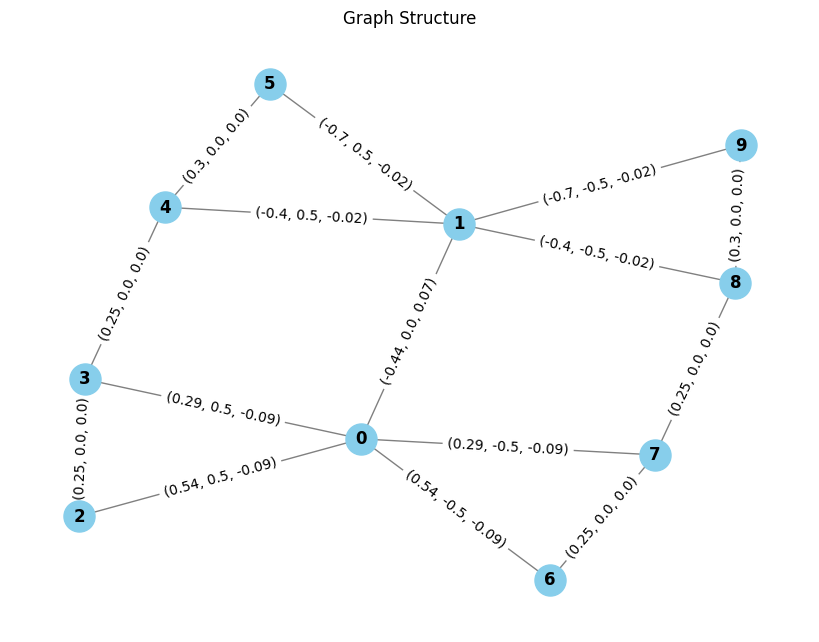

Data(x=[10, 277, 10], edge_index=[2, 15], edge_attr=[15, 3], y=[1, 277, 20], global_input=[1, 277, 4])


In [22]:
inputs_temp, targets_temp = dataset_aircraft[0]
graph = create_graph(inputs_temp, targets_temp)
visualize_graph(graph)
print(graph)

In [23]:
# Constants
EPOCHS = 2500
BATCH_SIZE = 1
LEARNING_RATE = 2e-4

In [24]:
graph_dataset = GraphDataset(dataset_aircraft)


pretrained_wing = wing_model_static
pretrained_canard = wing_model_static
pretrained_rotor1 = rotor1_model
pretrained_rotor2 = rotor2_model
pretrained_rotor3 = rotor3_model
pretrained_rotor4 = rotor4_model


# Ensure all parameters are trainable (for fine-tuning)
for param in pretrained_wing.parameters():
    param.requires_grad = False

for param in pretrained_canard.parameters():
    param.requires_grad = False

for param in pretrained_rotor1.parameters():
    param.requires_grad = False

for param in pretrained_rotor2.parameters():
    param.requires_grad = False

for param in pretrained_rotor3.parameters():
    param.requires_grad = False

for param in pretrained_rotor4.parameters():
    param.requires_grad = False




In [25]:
from torch.utils.data import random_split
# Define the split ratio
train_ratio = 0.7
val_ratio = 1-train_ratio

# Calculate split sizes
dataset_size = len(graph_dataset)
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Perform the split
train_dataset_aircraft, val_dataset_aircraft = random_split(graph_dataset, [train_size, val_size])

print("Train Dataset Size:", len(train_dataset_aircraft))
print("Validation Dataset Size:", len(val_dataset_aircraft))

train_dataloader = DataLoader(train_dataset_aircraft, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset_aircraft, batch_size=BATCH_SIZE, shuffle=True)


Train Dataset Size: 27
Validation Dataset Size: 12


In [26]:
def custom_loss(pred, target):
    return torch.mean((pred - target) ** 2) + 0.8 * torch.mean(torch.abs(pred - target))


In [27]:
hidden_dim = 200
global_input_dim = dataset_aircraft.data["time_varying_inputs"].shape[-1]
edge_input_dim = 3 
output_dim = dataset_aircraft.targets.shape[-1]

# composite_model = CompositeGNN(pretrained_wing, pretrained_canard, 
#                                 pretrained_rotorL1, pretrained_rotorL2,
#                                 pretrained_rotorL3, pretrained_rotorL4,
#                                 pretrained_rotorR1, pretrained_rotorR2,
#                                 pretrained_rotorR3, pretrained_rotorR4, 
#                                 global_input_dim, edge_input_dim, hidden_dim, output_dim).to(device)

scripted_model = RecurrentCompositeGNN(pretrained_canard,
                                            pretrained_wing,                              
                                            pretrained_rotor1, pretrained_rotor2,
                                            pretrained_rotor3, pretrained_rotor4,
                                            global_input_dim, edge_input_dim, hidden_dim, output_dim).to(device)

# scripted_model = torch.jit.script(composite_model)

# Define optimizer and loss function
optimizer_composite = torch.optim.Adam(scripted_model.parameters(), lr=LEARNING_RATE)
# criterion = nn.MSELoss()
criterion = custom_loss



In [28]:
train_losses = []
eval_losses = []

print("[INFO] training the network...")

# Training loop
for epoch in range(EPOCHS):
    scripted_model.train()
    running_loss = 0.0
    
    for graph_batch in train_dataloader:
               
        node_inputs = (graph_batch.x).to(device)
        edge_index = graph_batch.edge_index
        edge_attr = graph_batch.edge_attr
        global_inputs = graph_batch.global_input
        targets = (graph_batch.y).to(device)

        node_inputs = node_inputs.to(device)
        edge_index = edge_index.to(device)
        edge_attr = edge_attr.to(device)
        global_inputs = global_inputs.to(device)

        # print("Node Inputs:", node_inputs.shape)

        # break

        optimizer_composite.zero_grad()
        outputs = scripted_model(node_inputs, targets, edge_index, edge_attr, global_inputs, BATCH_SIZE, num_nodes = 10)
        # print("Outputs:", outputs.shape)
        
        # break
        # print("Outputs:", outputs.shape)
        # print("Targets:", targets_batch.shape)
        
        # Compute loss
        loss = criterion(outputs, targets)
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(scripted_model.parameters(), max_norm=1.0)

        optimizer_composite.step()

        running_loss += loss.item()
    avg_train_loss = running_loss/len(train_dataloader)
    train_losses.append(avg_train_loss)

    # break
    # Evaluation loop
    scripted_model.eval()
    eval_loss = 0.0

    with torch.no_grad():

        for graph_batch in val_dataloader:
                      
            node_inputs = (graph_batch.x).to(device)
            edge_index = graph_batch.edge_index
            edge_attr = graph_batch.edge_attr
            global_inputs = graph_batch.global_input
            targets = (graph_batch.y).to(device)

            node_inputs = node_inputs.to(device)
            edge_index = edge_index.to(device)
            edge_attr = edge_attr.to(device)
            global_inputs = global_inputs.to(device)

            # Forward pass

            outputs = scripted_model(node_inputs, targets, edge_index, edge_attr, global_inputs, BATCH_SIZE, num_nodes = 10)   

            # Compute loss
            loss = criterion(outputs, targets)

            eval_loss += loss.item()

        avg_eval_loss = eval_loss / len(val_dataloader)
        eval_losses.append(avg_eval_loss)


    
    print(f'Epoch [{epoch+1}/{EPOCHS}],\n Training Loss: {running_loss/len(train_dataloader):.8f}')
    print(f'Evaluation Loss: {eval_loss/len(val_dataloader):.8f}')

    

print("[INFO] Finished training the network...")

[INFO] training the network...
Epoch [1/2500],
 Training Loss: 0.41318254
Evaluation Loss: 0.19880065
Epoch [2/2500],
 Training Loss: 0.36645080
Evaluation Loss: 0.19534247
Epoch [3/2500],
 Training Loss: 0.36209730
Evaluation Loss: 0.18874063
Epoch [4/2500],
 Training Loss: 0.35955792
Evaluation Loss: 0.19313060
Epoch [5/2500],
 Training Loss: 0.36084460
Evaluation Loss: 0.19098203
Epoch [6/2500],
 Training Loss: 0.35965128
Evaluation Loss: 0.18936288
Epoch [7/2500],
 Training Loss: 0.36155070
Evaluation Loss: 0.20600175
Epoch [8/2500],
 Training Loss: 0.36230516
Evaluation Loss: 0.19476564
Epoch [9/2500],
 Training Loss: 0.35953128
Evaluation Loss: 0.19024109
Epoch [10/2500],
 Training Loss: 0.35681568
Evaluation Loss: 0.19793566
Epoch [11/2500],
 Training Loss: 0.35658431
Evaluation Loss: 0.18769082
Epoch [12/2500],
 Training Loss: 0.35542988
Evaluation Loss: 0.18915538
Epoch [13/2500],
 Training Loss: 0.35411392
Evaluation Loss: 0.18545702
Epoch [14/2500],
 Training Loss: 0.3531643

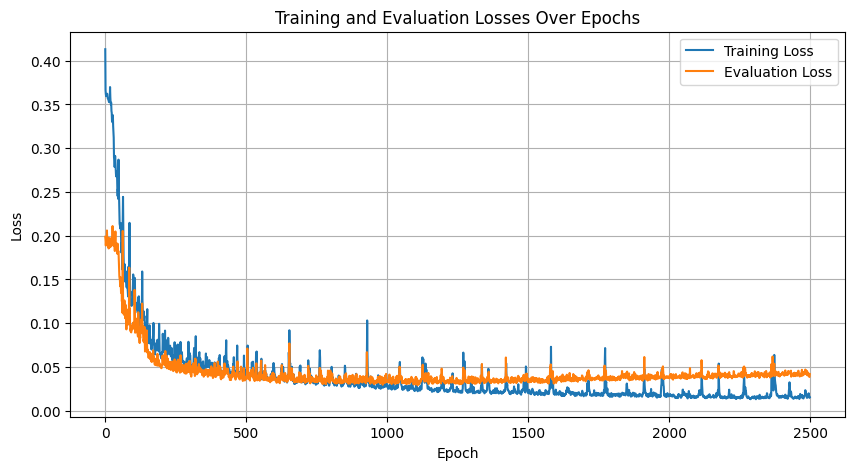

In [29]:
# Plotting the training and evaluation losses
plt.figure(figsize=(10, 5))
plt.plot((train_losses), label='Training Loss')
plt.plot((eval_losses), label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
import datetime
# date = datetime.date.today()

# # Save Python model

# save_path =  '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/vehicle/{}_aircraft_customoss_lr{}_e{}_hidDim{}.pth'.format(date, LEARNING_RATE, EPOCHS, hidden_dim)
# print("The model will be saved as the following:\n {}".format(save_path))


# torch.save(composite_model.state_dict(), save_path)

In [31]:
# # Save Scripted model
# save_path =  '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/vehicle/{}_scripted_rotorSystem_customoss_lr{}_e{}_hidDim{}.pt'.format(date, LEARNING_RATE, EPOCHS, hidden_dim)
# print("The model will be saved as the following:\n {}".format(save_path))


# torch.jit.save(scripted_model, save_path)

## Test the model

In [32]:

def plot_model_vs_ground_truth(time, model_outputs, ground_truths, labels, save_csv=False, csv_filename="NN_predictions.csv"):
    """
    Plot model predictions vs ground truth for aerodynamic coefficients.
    Optionally saves the NN predictions to a CSV file.

    Args:
        time (array-like): Time steps.
        model_outputs (dict): Dictionary containing model predictions.
        ground_truths (dict): Dictionary containing ground truth values.
        labels (list): List of keys for extracting the values (e.g., ["Cl_1", "Cd_1", ..., "Cq_R4"]).
        save_csv (bool): If True, saves predictions to a CSV file.
        csv_filename (str): Name of the CSV file to save predictions.
    """
    num_plots = len(labels)  # Should be 20
    rows, cols = 5, 4  # Define subplot grid

    fig, axes = plt.subplots(rows, cols, figsize=(10, 15))
    axes = axes.flatten()  # Convert to a 1D list for easy indexing

    # Create a dictionary to store CSV data
    csv_data = {"Time": time}

    for i, key in enumerate(labels):
        ax = axes[i]
        ax.plot(ground_truths[key], label="Ground Truth", linestyle='dashed', color='black')
        ax.plot(model_outputs[key][5:], label="Model Prediction", linestyle='solid', color='blue')
        ax.set_title(key)
        ax.set_xlabel("Time")
        ax.set_ylabel("Coefficient Value")
        ax.legend()
        ax.grid(True)

        # Store data for CSV
        csv_data[f"{key}_NN"] = model_outputs[key]
        csv_data[f"{key}_Truth"] = ground_truths[key]

    # Remove empty subplots if `num_plots < rows*cols`
    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # Save predictions to CSV if enabled
    if save_csv:
        df = pd.DataFrame(csv_data)
        df.to_csv(csv_filename, index=False)
        print(f"Neural Network predictions saved to '{csv_filename}'")



Simulation Case: eMO_hover_v0_r1600


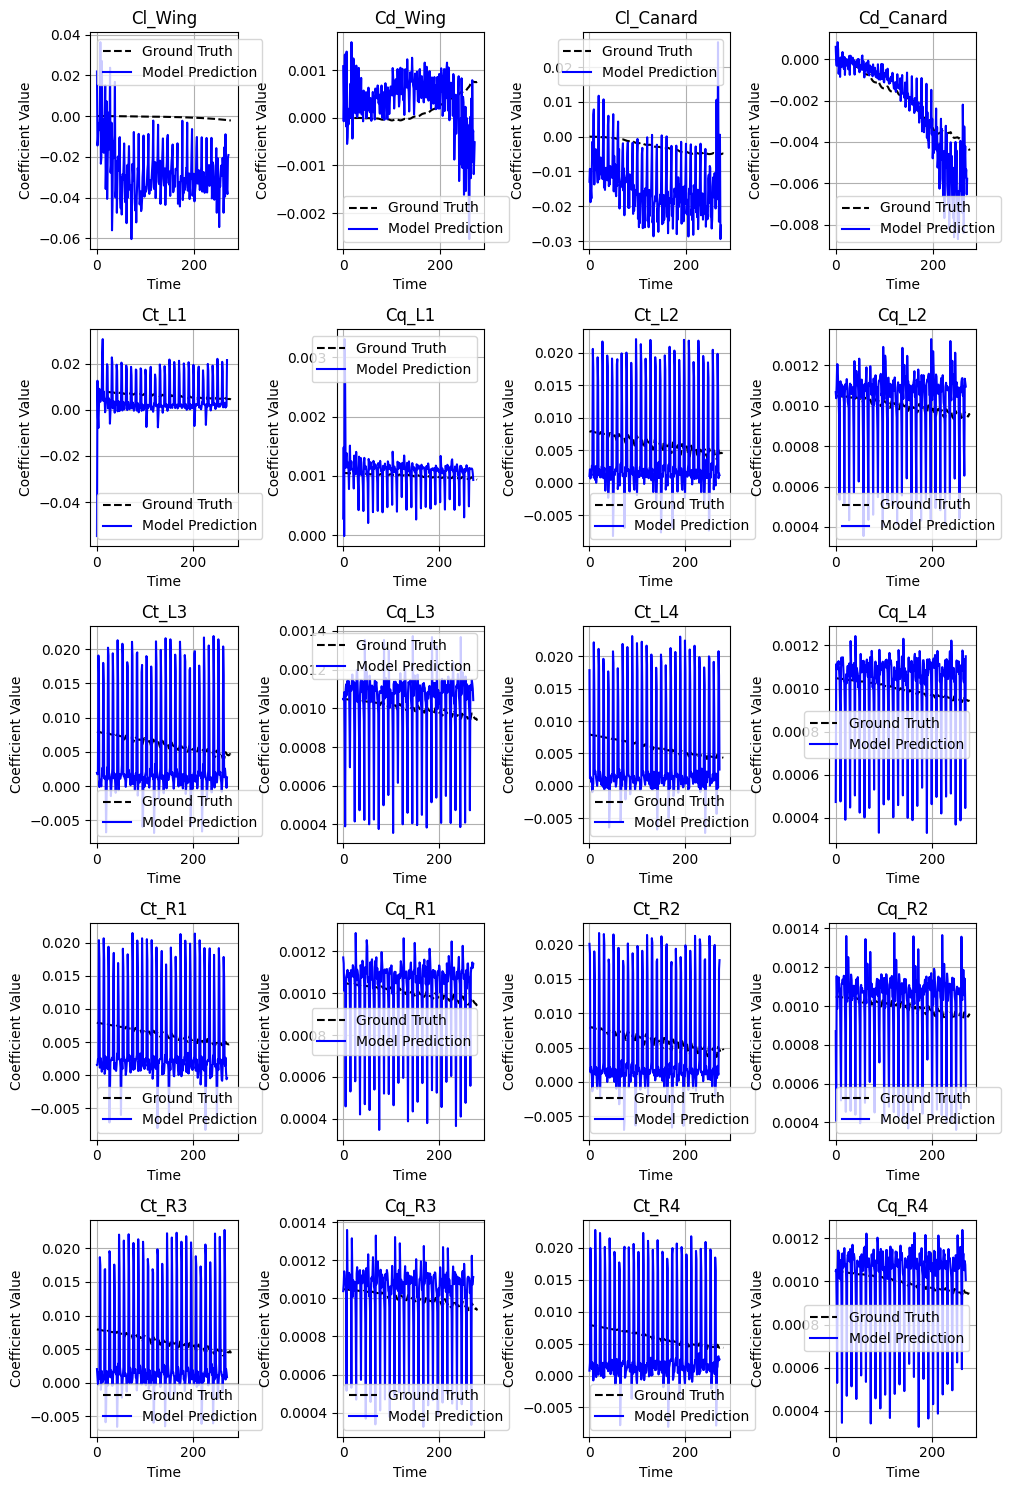

Simulation Case: eMO_hover_v10_r2200_a3


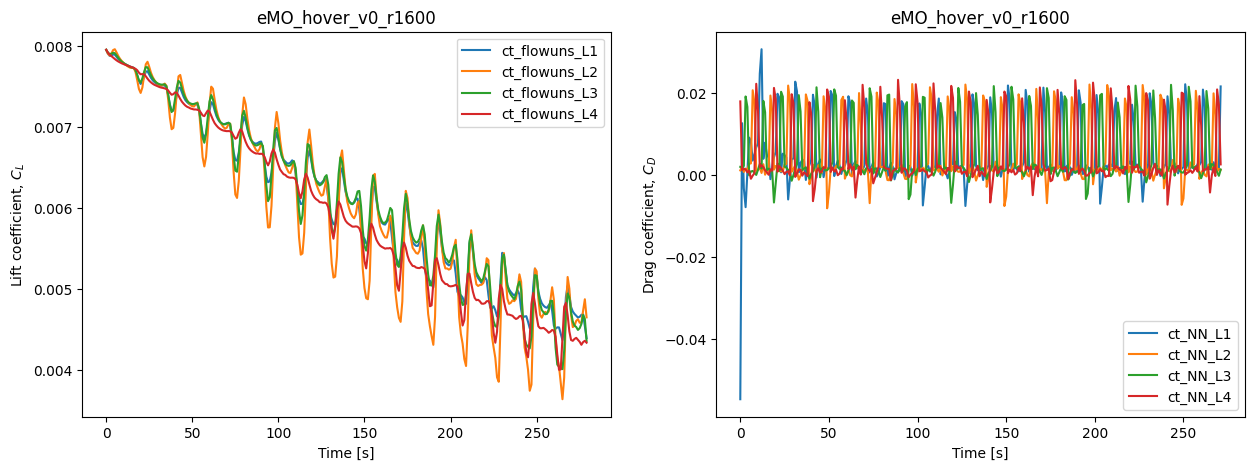

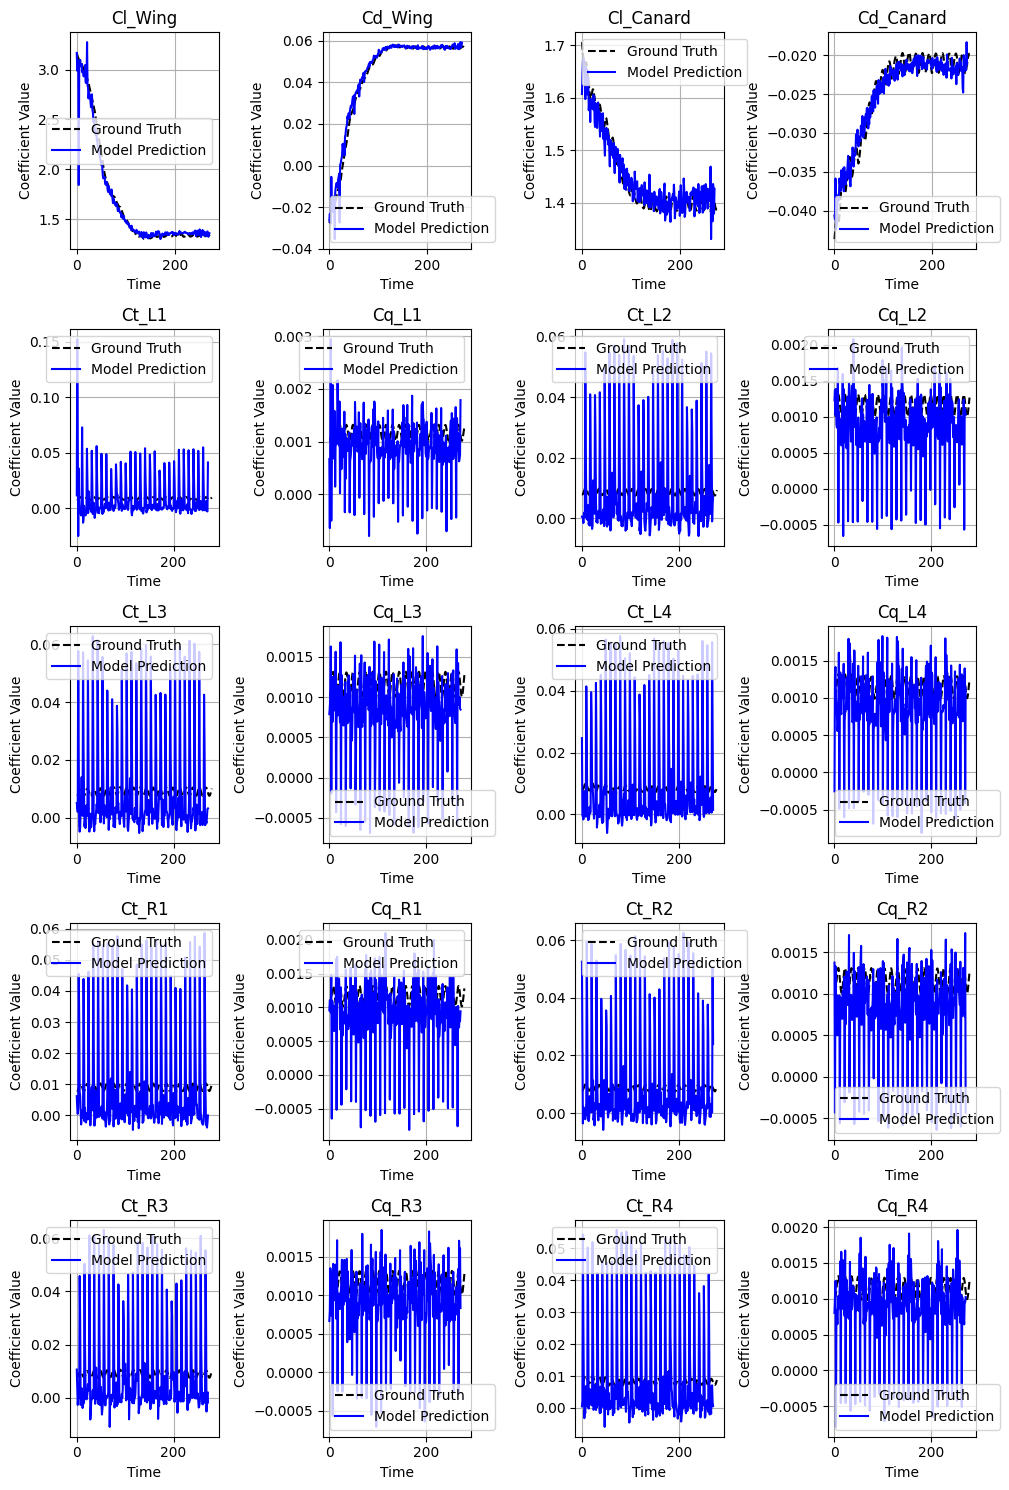

Simulation Case: eMO_hover_v12_r1600_a1


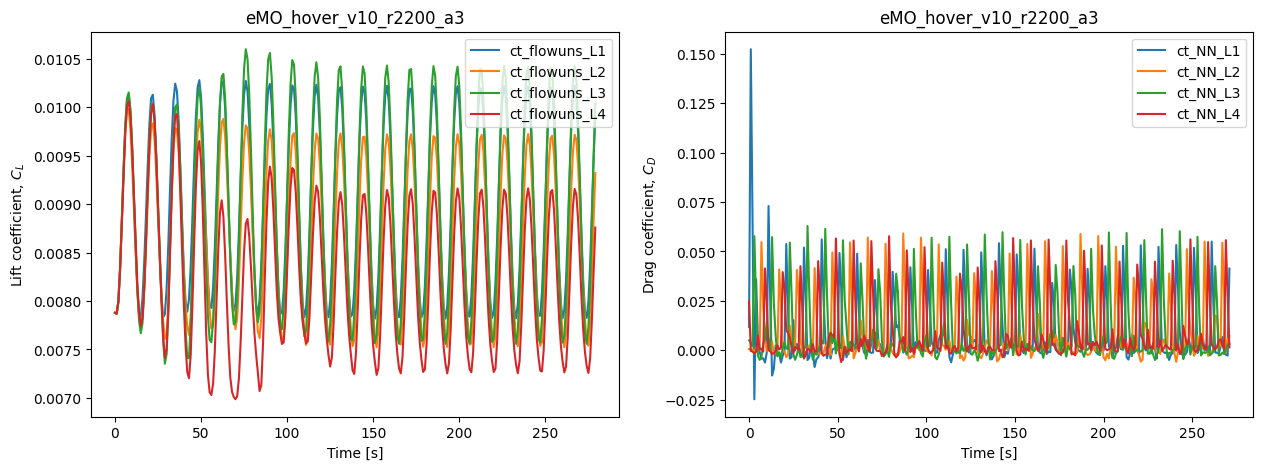

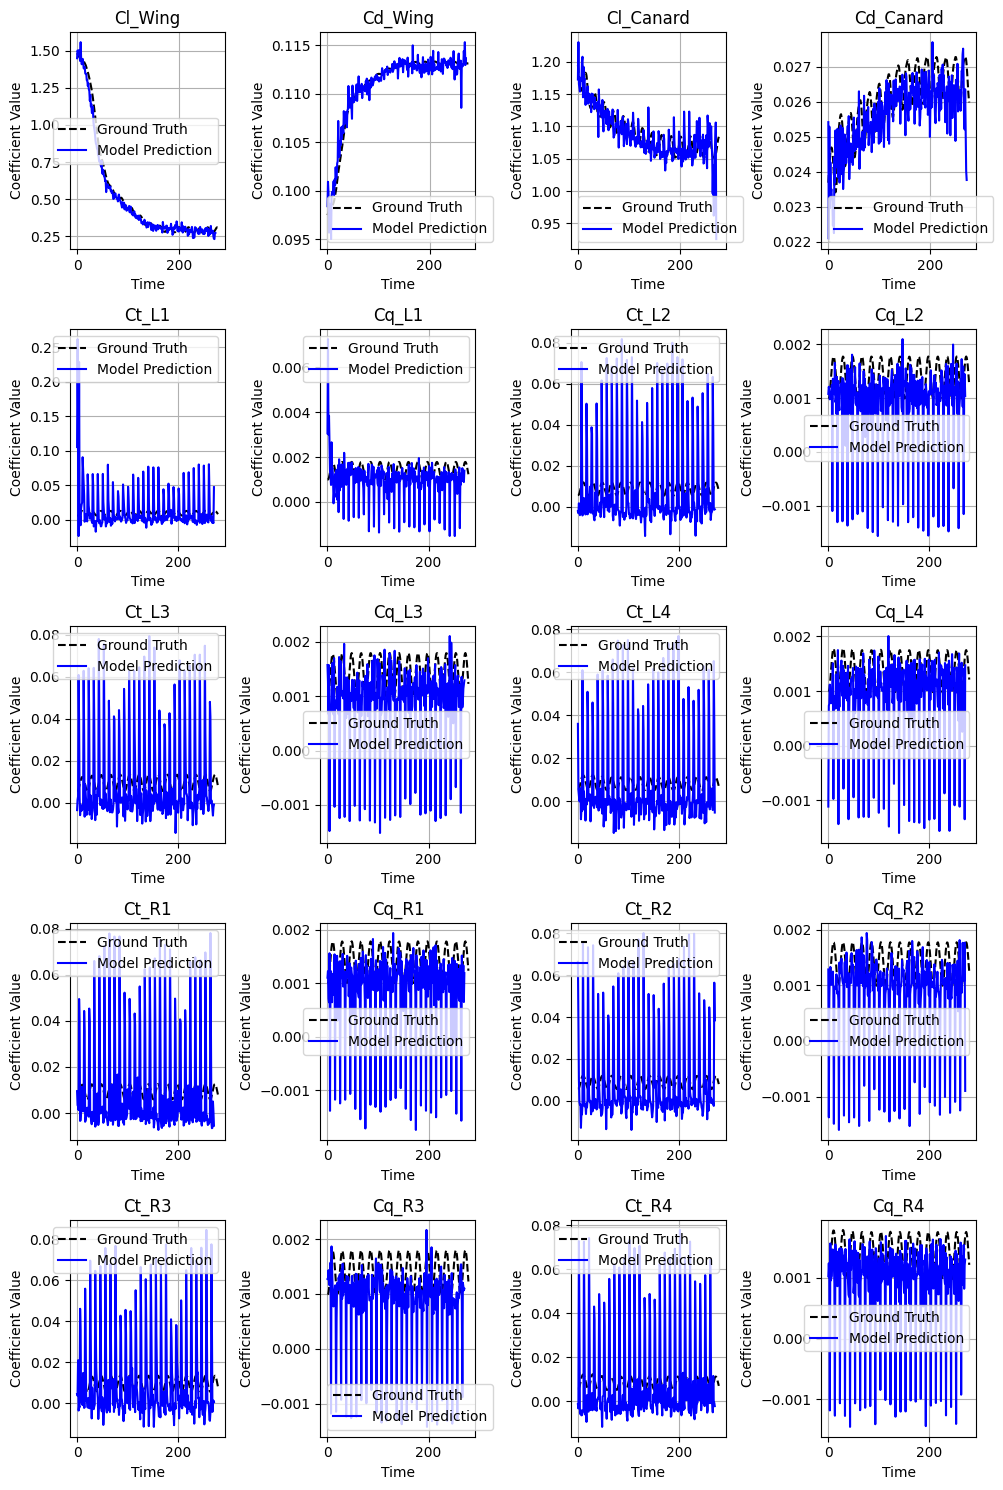

Simulation Case: eMO_hover_v12_r2000_a1


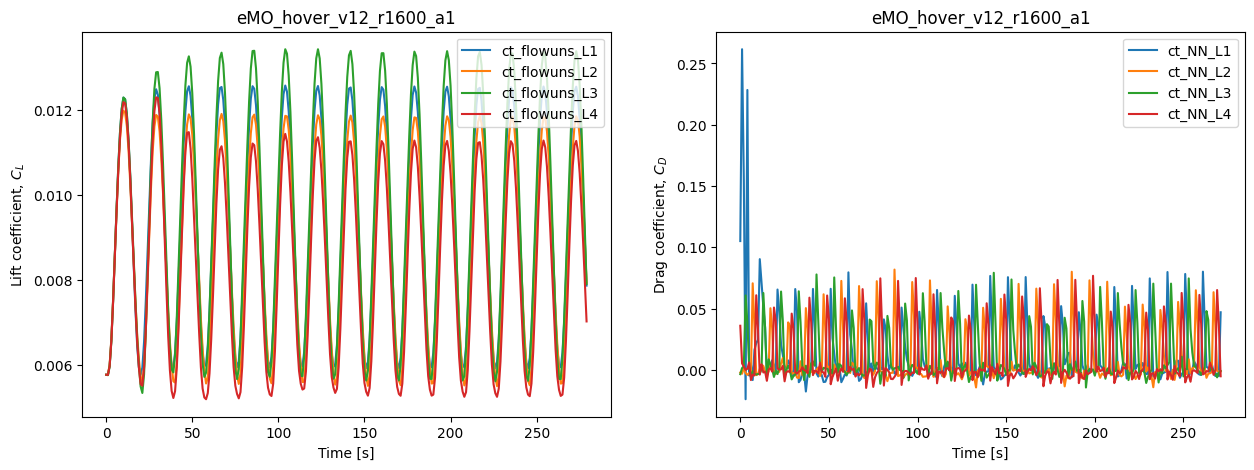

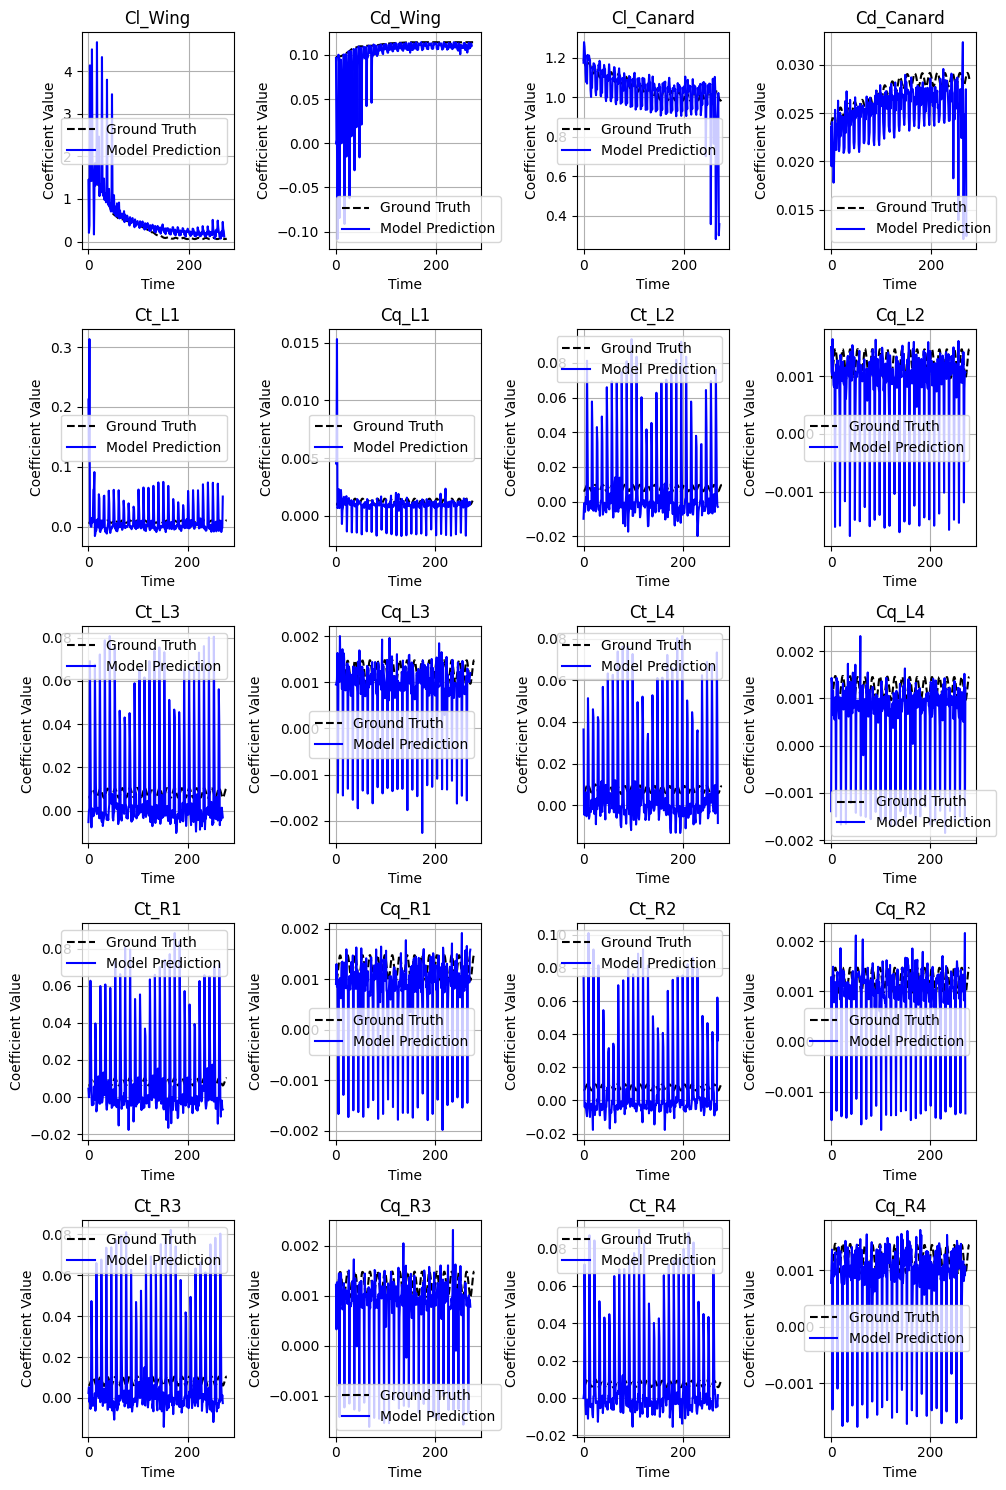

Simulation Case: eMO_hover_v2_r1600


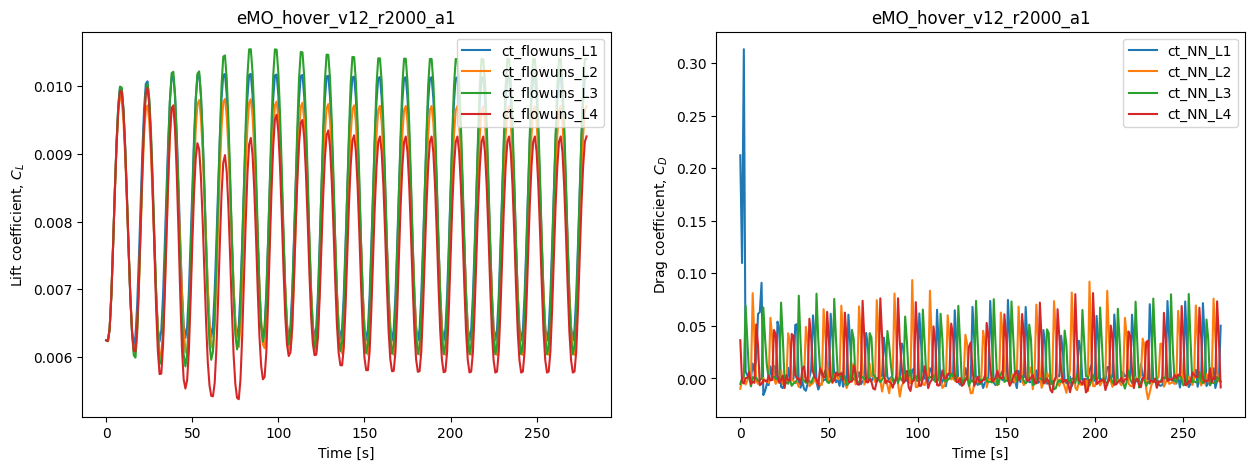

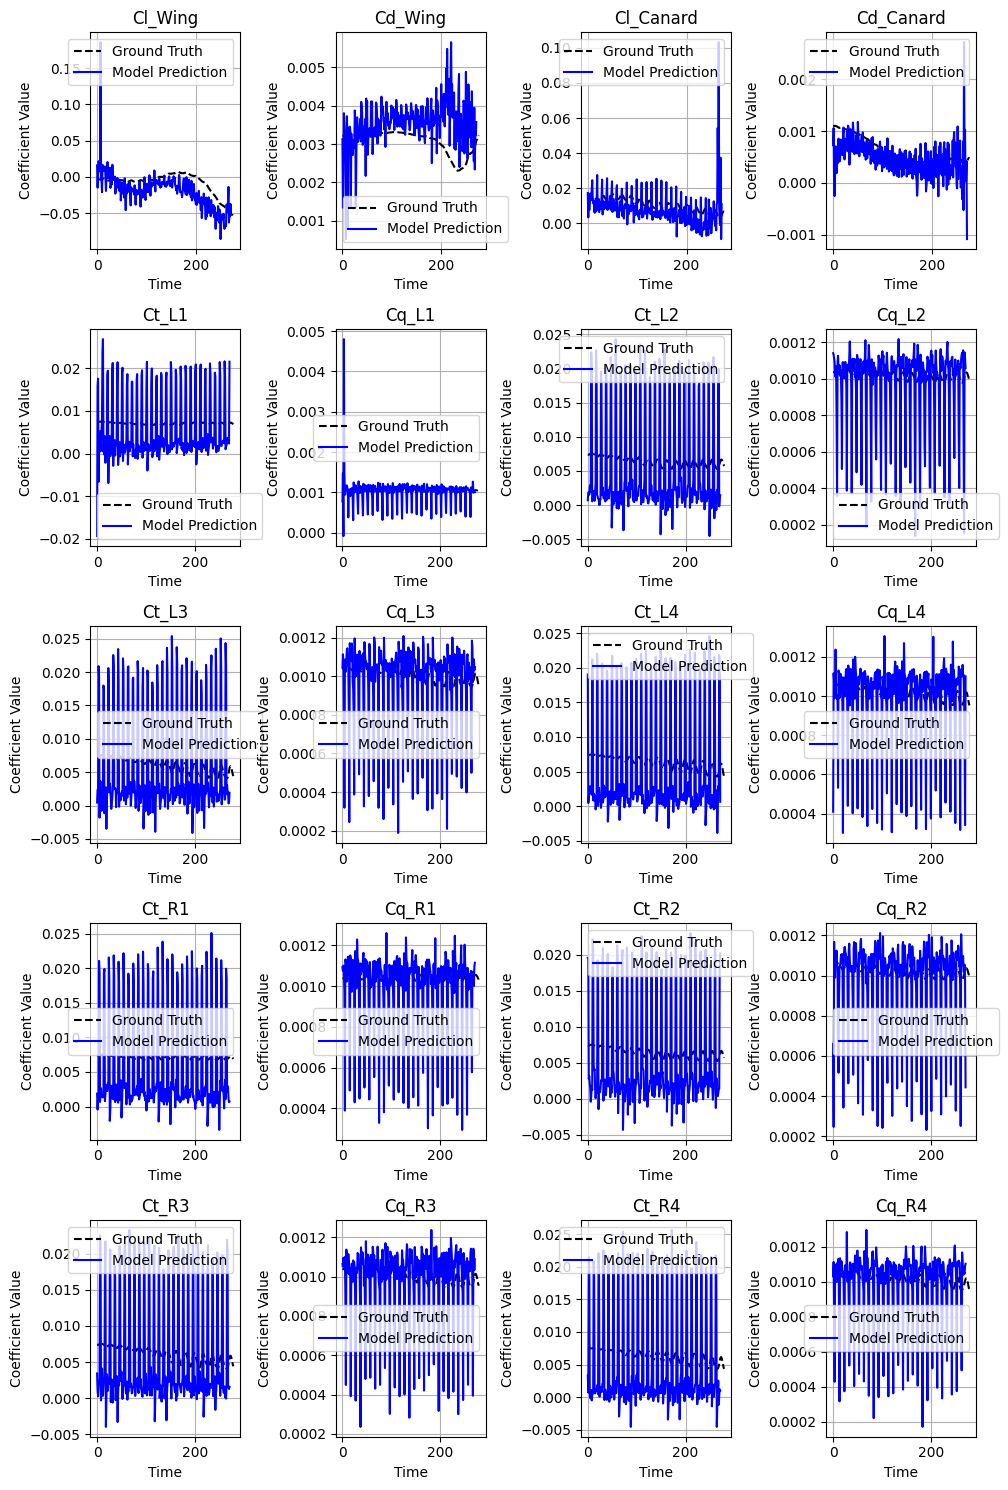

Simulation Case: eMO_hover_v4_r2000_a5


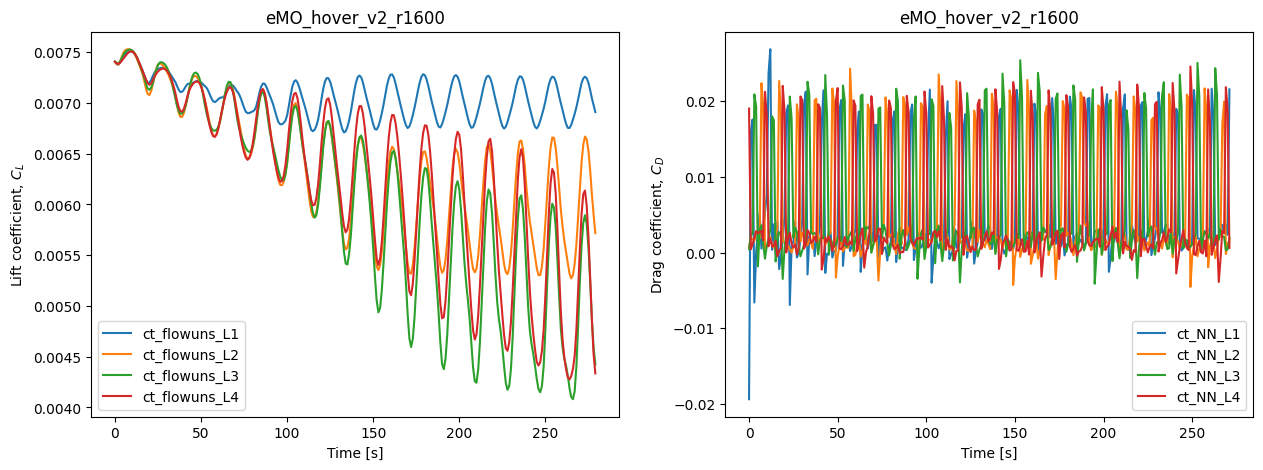

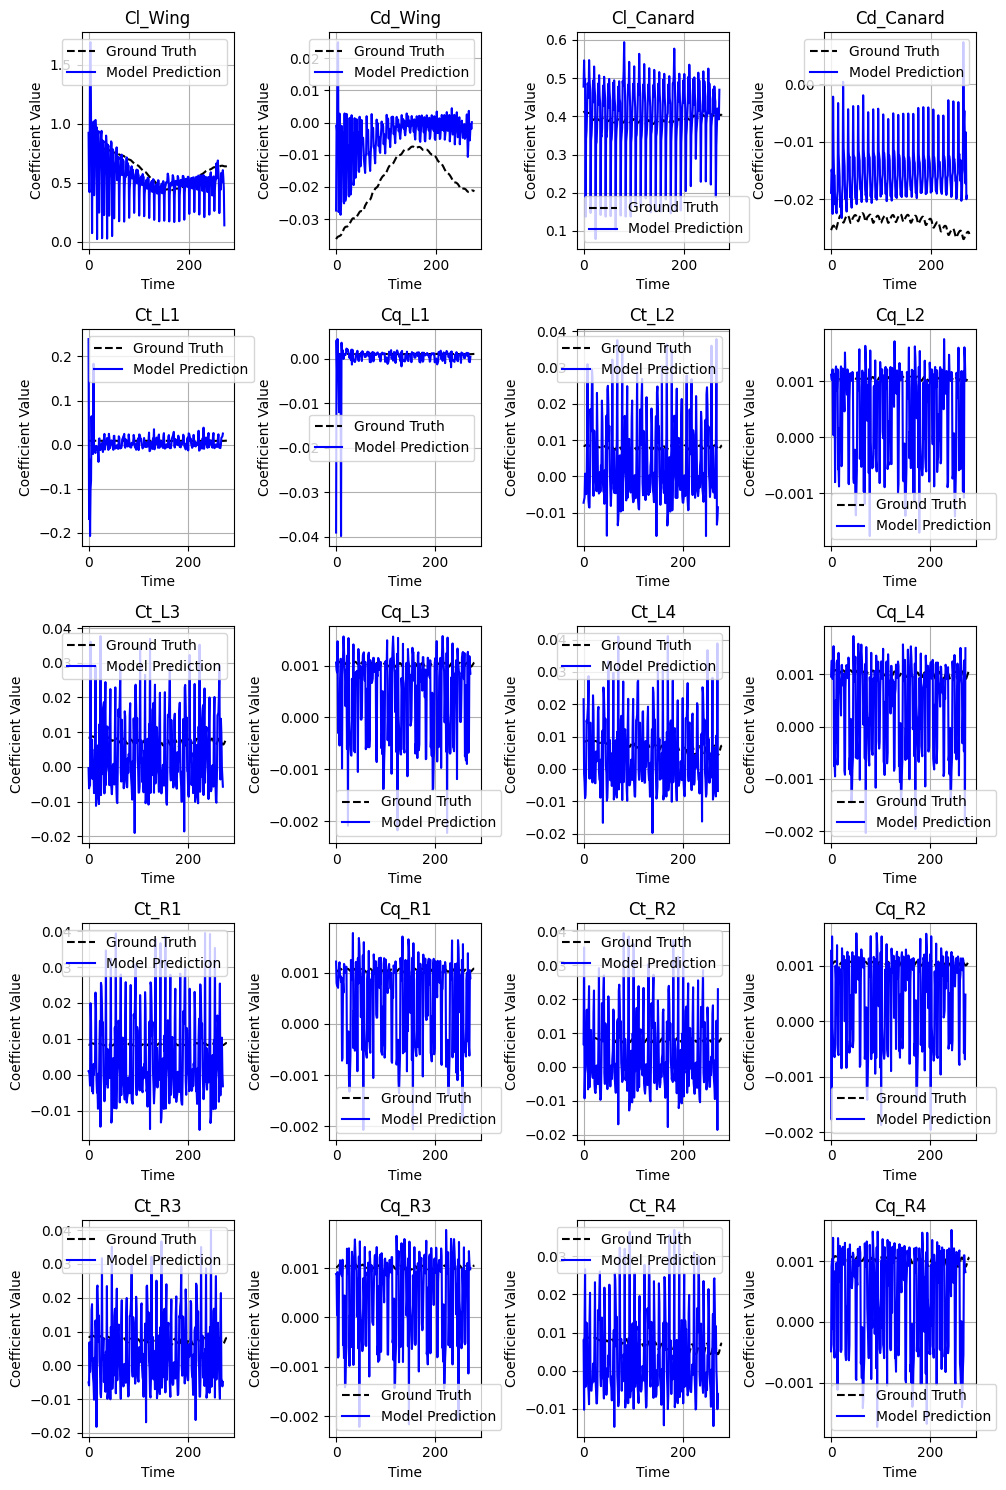

Simulation Case: eMO_hover_v5_r1800_a1


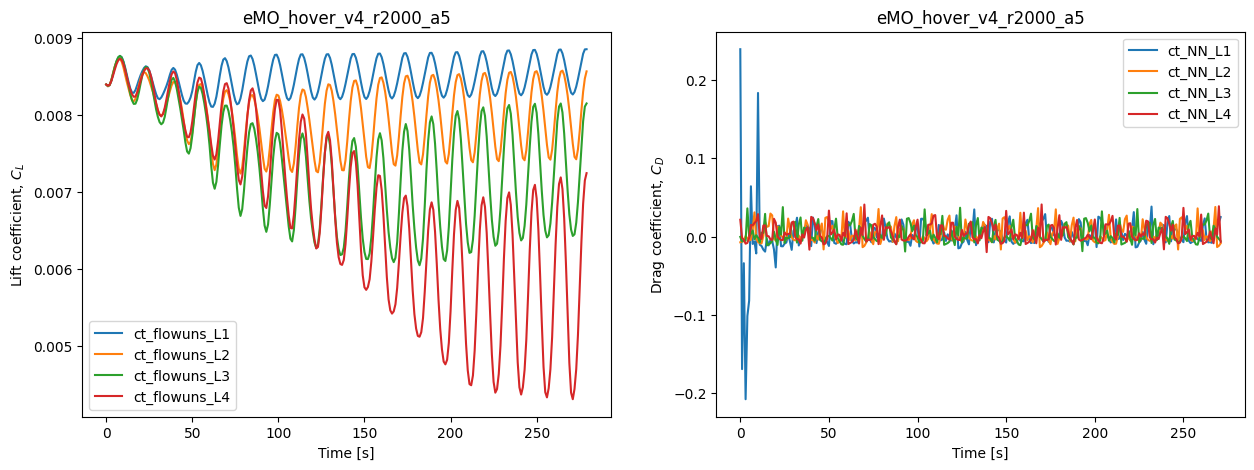

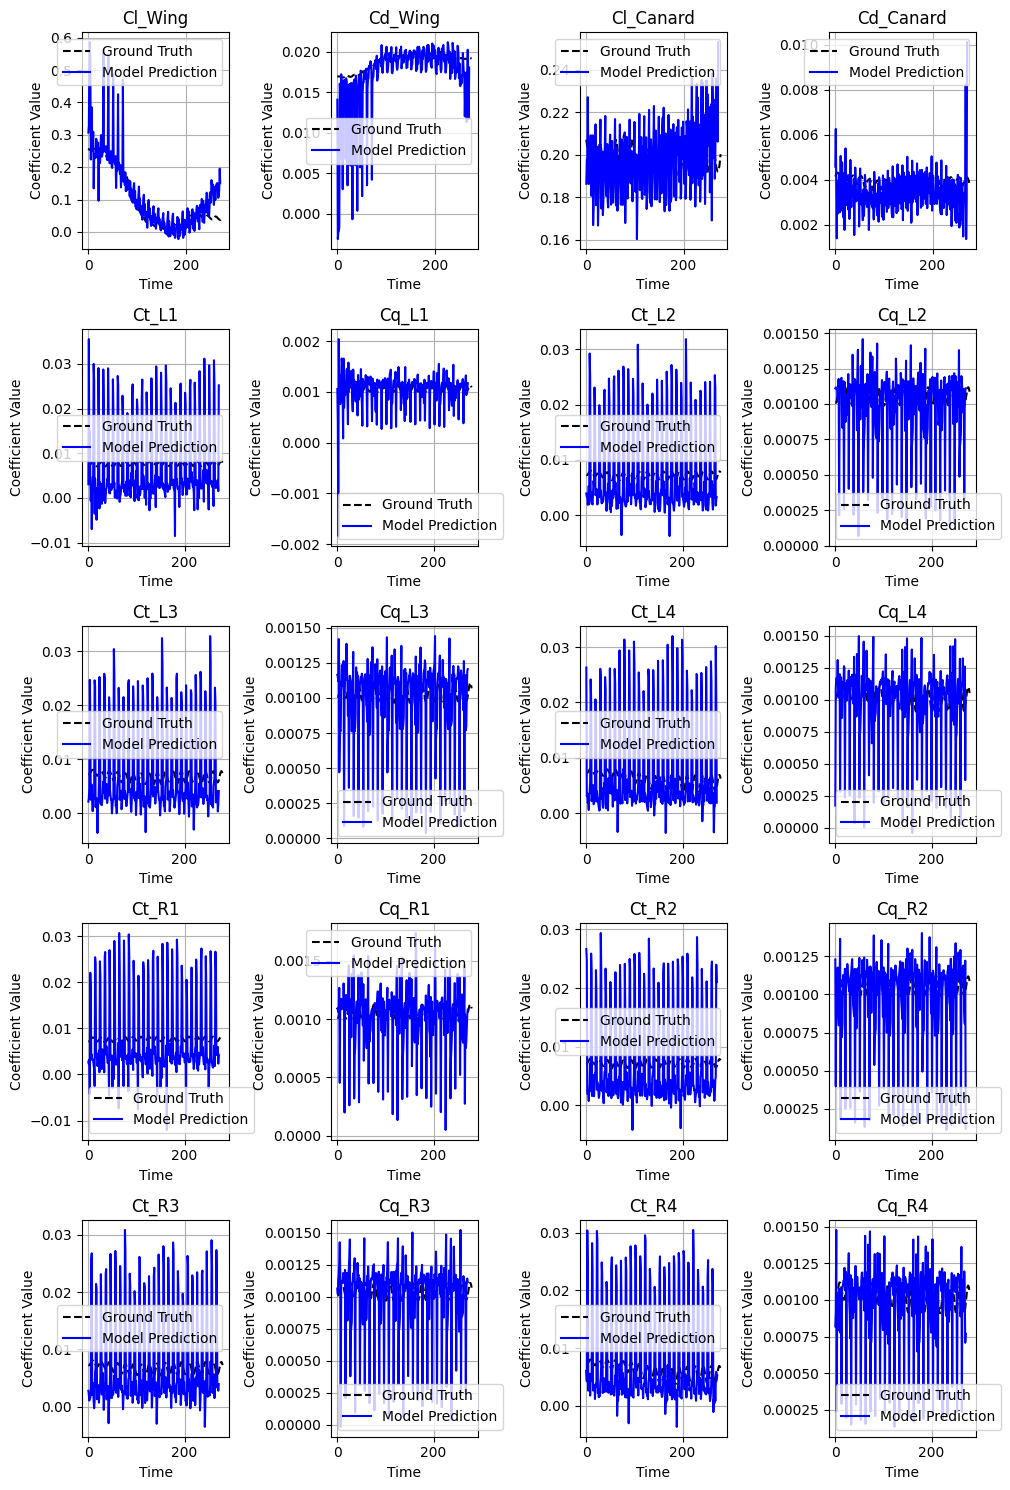

Simulation Case: eMO_hover_v6_r2000_a5


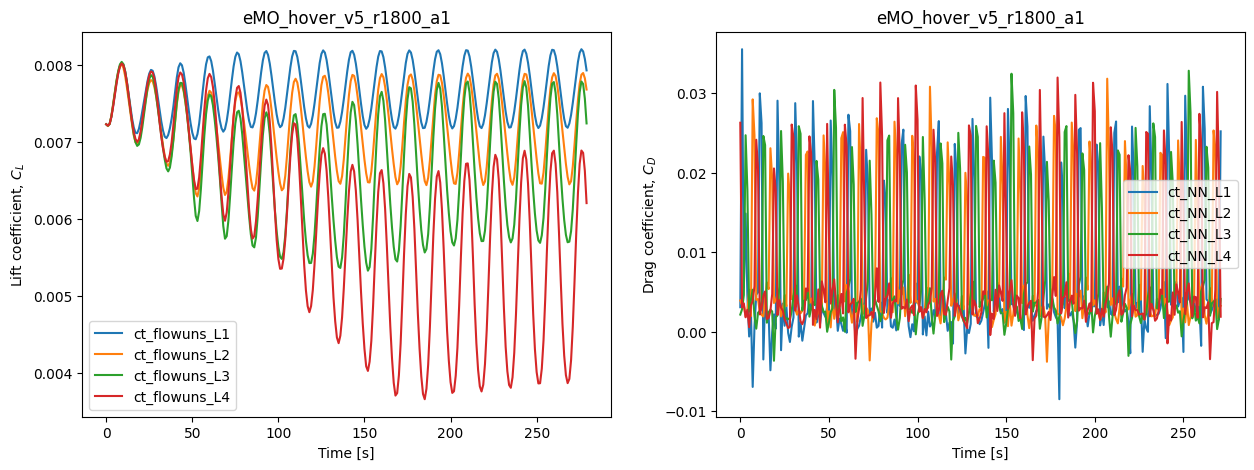

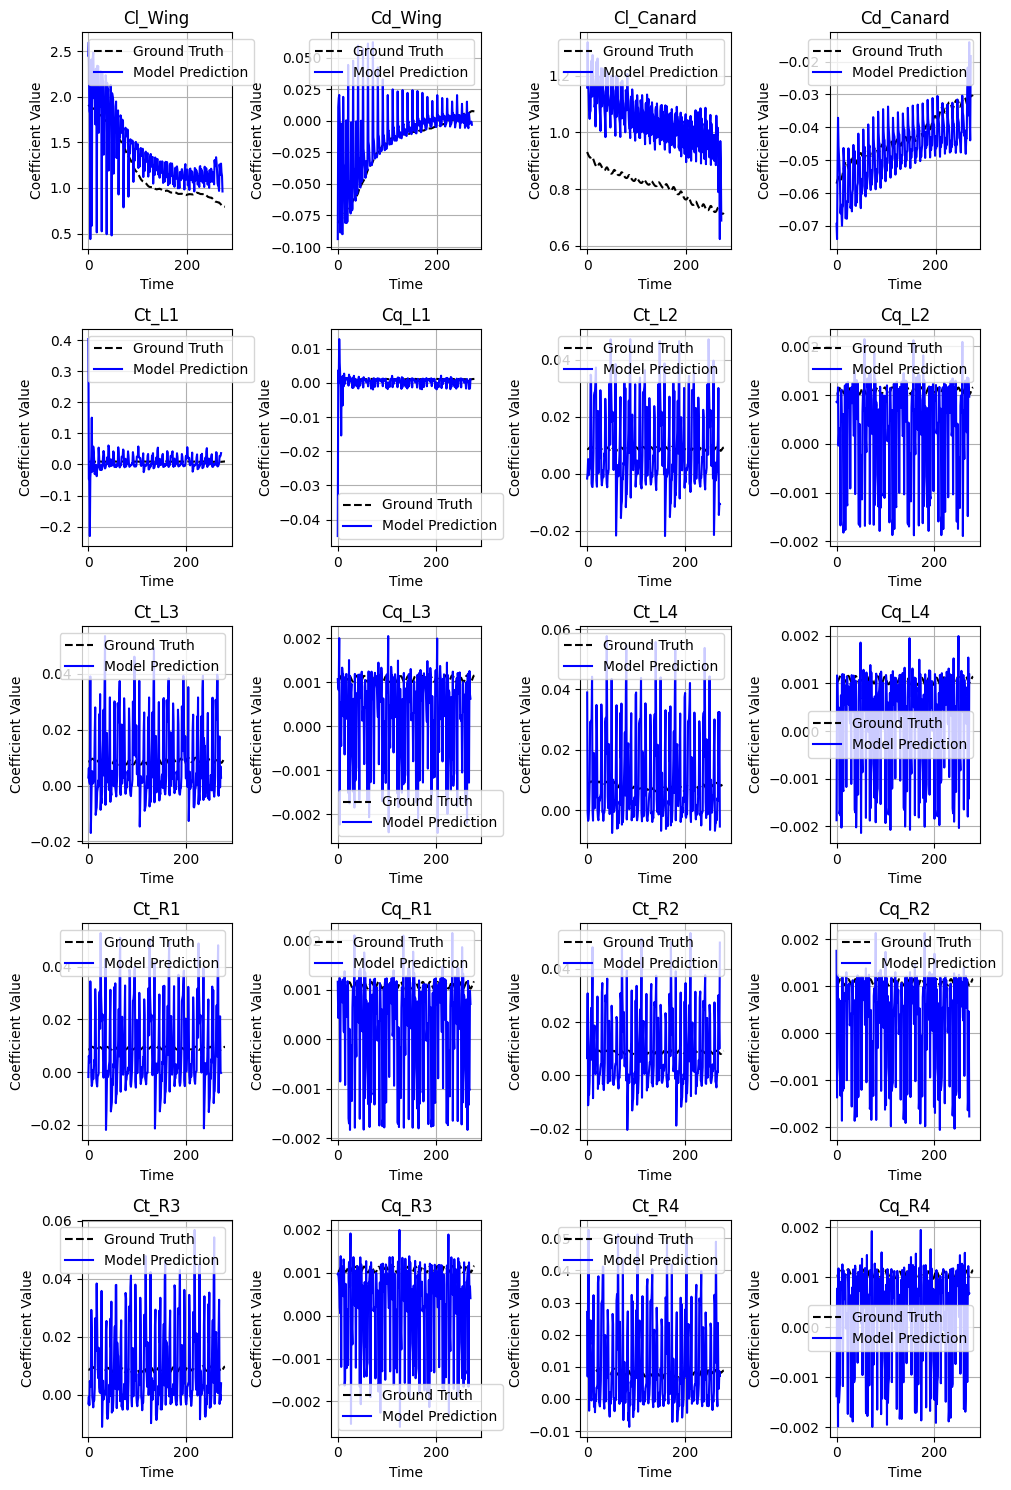

Simulation Case: eMO_hover_v8_r1800_a1


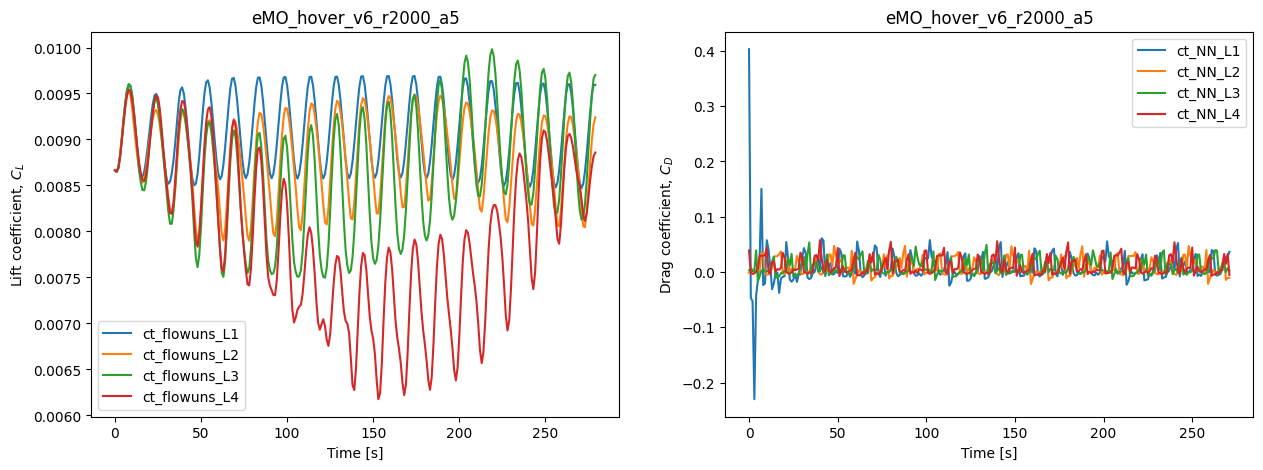

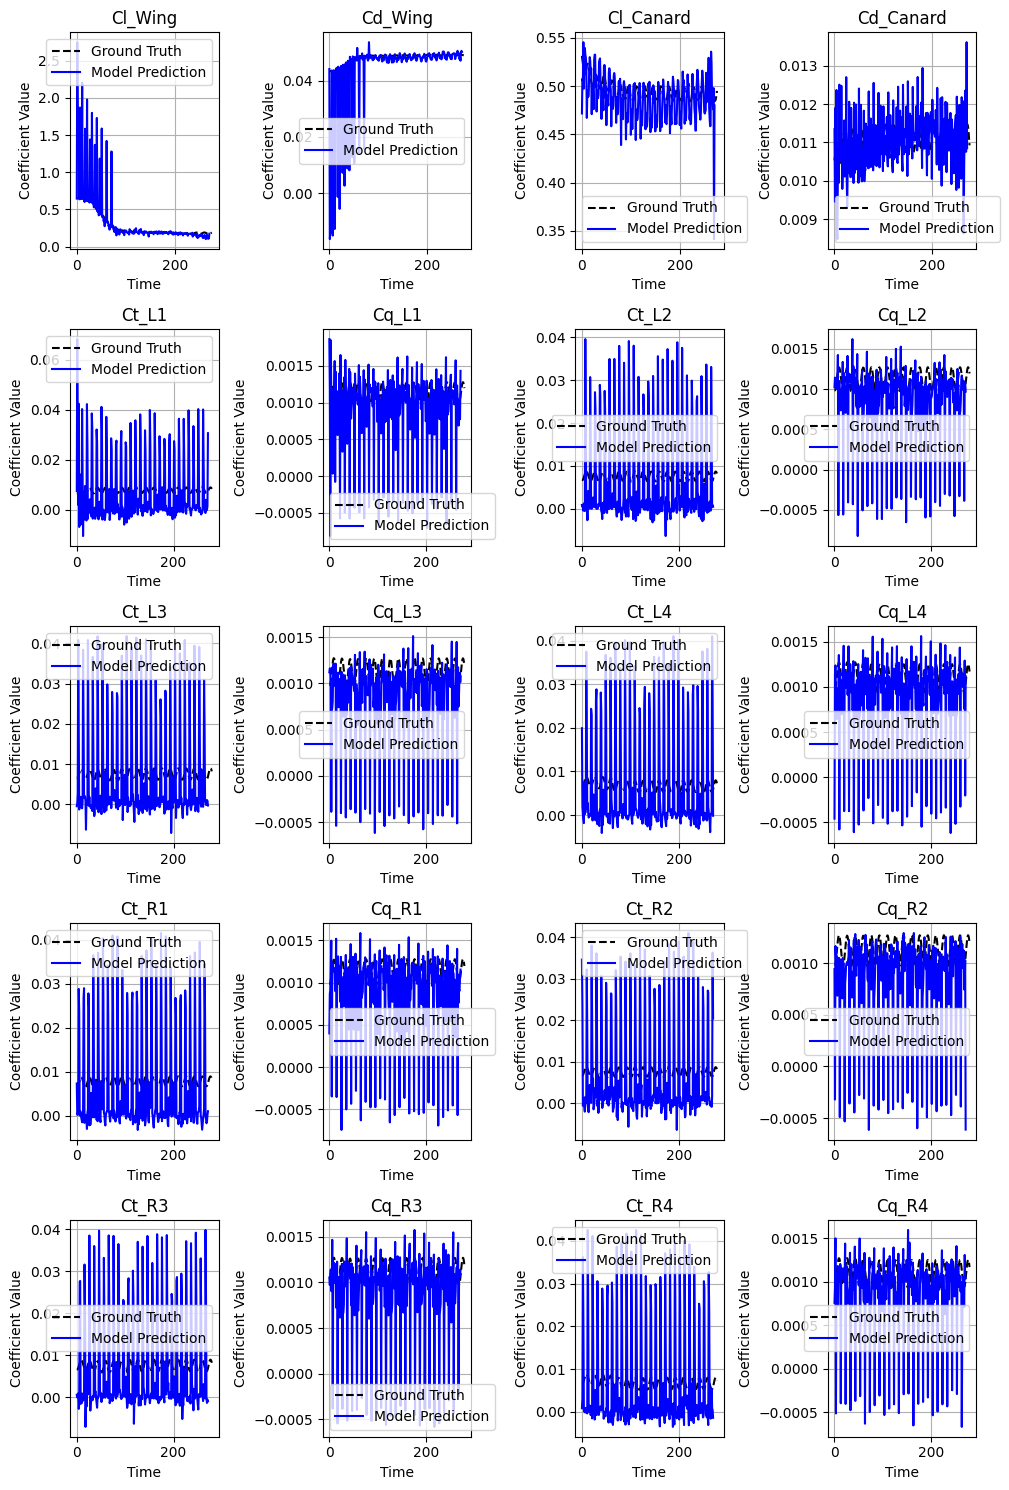

Simulation Case: eMO_hover_v8_r2000_a1


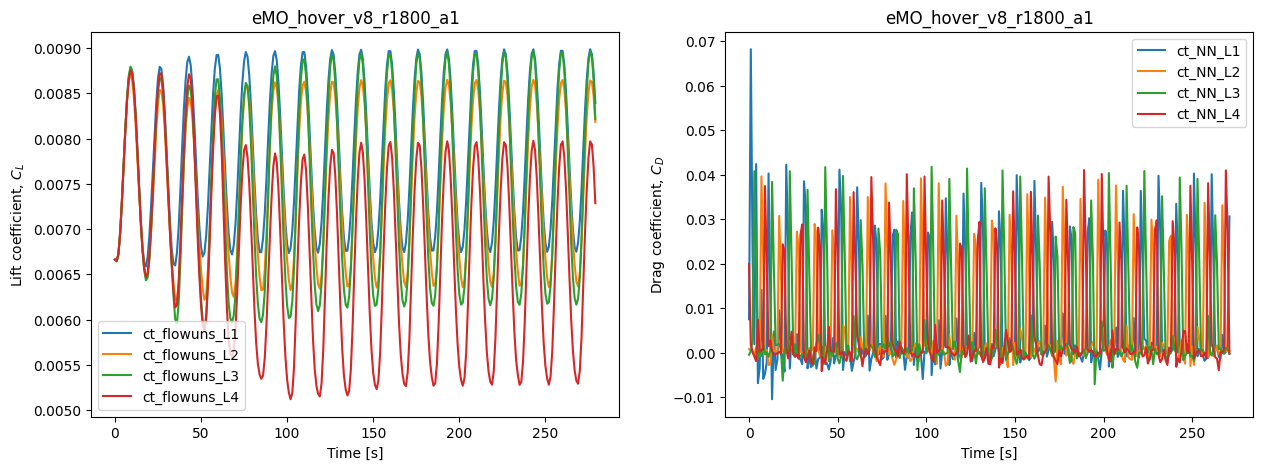

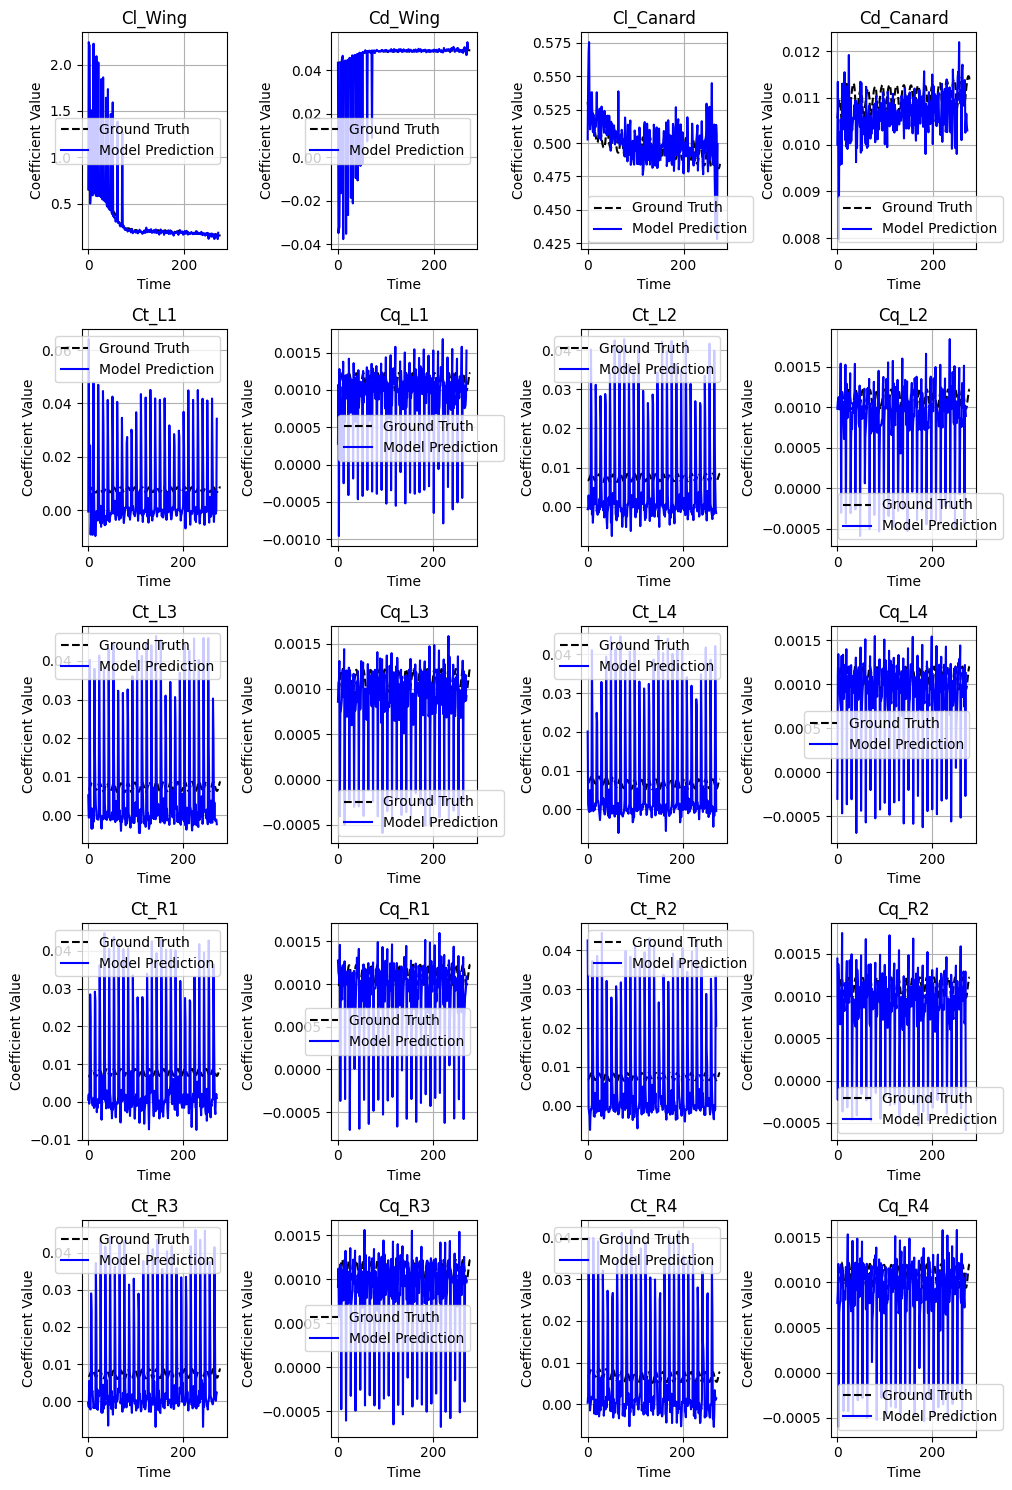

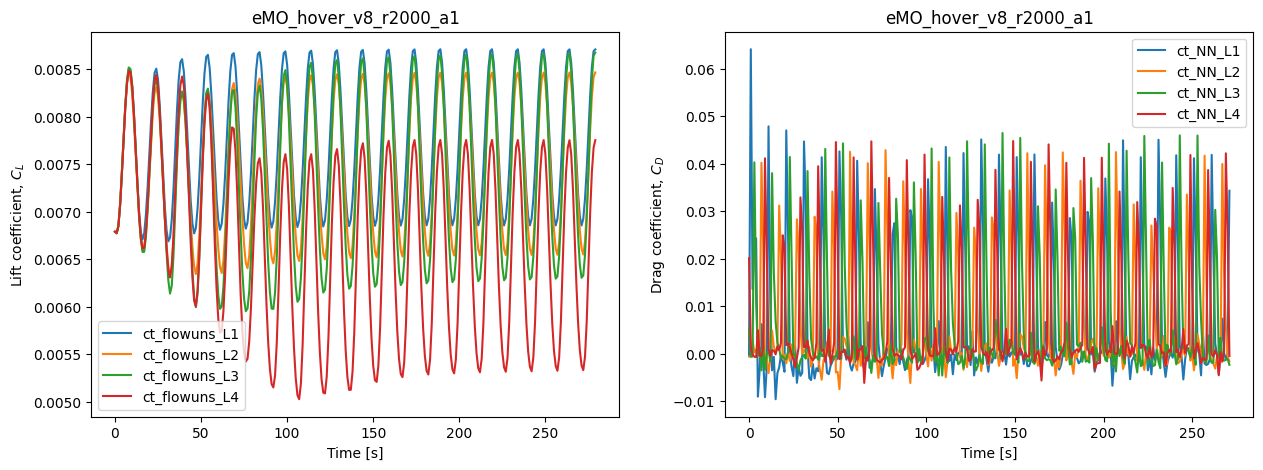

In [33]:
 
from sklearn.metrics import mean_squared_error 

root_test_base = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/FLOWUnsteady_simulations/aircraft_data/testing_data/'
batch_size_test = 1

for simulation_case in os.listdir(root_test_base):

    root_test_dir = root_test_base+simulation_case

    # Canard dataset
    dataset_canard_test = WingDataset(root_test_dir, 
                                    af_model_ESCNN_Cl=af_model_ESCNN_Cl, 
                                    af_model_ESCNN_Cd=af_model_ESCNN_Cd,
                                    airfoil_cl=airfoil_cl, 
                                    airfoil_cd=airfoil_cd, 
                                    device=device,
                                    wing_name = 'Canard',     # select 'wing_main' or 'Canard'  
                                    subdir_condition=subdir_condition_wing)

    inputs_canard_test, outputs_canard_test = dataset_canard_test[0:]

    input_tensor_canard_test = inputs_canard_test
    input_tensor_canard_test = inputs_canard_test.squeeze(1)  # Reshaping
    # print("Input shape (Canard dataset):", input_tensor_canard.shape)
    output_tensor_canard_test = outputs_canard_test.squeeze(1)
    # print("Output shape (Canard dataset):",output_tensor_canard.shape)

    dataset_wing_test = WingDataset(root_test_dir, 
                                    af_model_ESCNN_Cl=af_model_ESCNN_Cl, 
                                    af_model_ESCNN_Cd=af_model_ESCNN_Cd,
                                    airfoil_cl=airfoil_cl, 
                                    airfoil_cd=airfoil_cd, 
                                    device=device,
                                    wing_name = 'wing_main',     # select 'wing_main' or 'Canard'  
                                    subdir_condition=subdir_condition_wing)
    
    inputs_wing_test, outputs_wing_test = dataset_wing_test[0:]

    input_tensor_wing_test = inputs_wing_test
    input_tensor_wing_test = inputs_wing_test.squeeze(1)  # Reshaping
    # print("Input shape (Wing dataset):", input_tensor_wing.shape)
    output_tensor_wing_test = outputs_wing_test.squeeze(1)
    # print("Output shape (Wing dataset):",output_tensor_wing.shape)


    # dataset - Rotor L1
    dataset_rotor_L1_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'L1',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rL1_test, outputs_rL1_test = dataset_rotor_L1_test[0:]

    input_tensor_rL1_test = inputs_rL1_test.squeeze(1)  # Reshaping
    # print("Input shape (rotor - L1):", input_tensor_rL1.shape) 
    output_tensor_rL1_test = outputs_rL1_test.squeeze(1)
    # print("Output shape (rotor - L1):",output_tensor_rL1.shape)

    dataset_rotor_L2_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'L2',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rL2_test, outputs_rL2_test = dataset_rotor_L2_test[0:]

    input_tensor_rL2_test = inputs_rL2_test.squeeze(1)  # Reshaping
    output_tensor_rL2_test = outputs_rL2_test.squeeze(1)

    dataset_rotor_L3_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'L3',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rL3_test, outputs_rL3_test = dataset_rotor_L3_test[0:]

    input_tensor_rL3_test = inputs_rL3_test.squeeze(1)  # Reshaping
    output_tensor_rL3_test = outputs_rL3_test.squeeze(1)

    dataset_rotor_L4_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'L4',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rL4_test, outputs_rL4_test = dataset_rotor_L4_test[0:]

    input_tensor_rL4_test = inputs_rL4_test.squeeze(1)  # Reshaping
    output_tensor_rL4_test = outputs_rL4_test.squeeze(1)

    # dataset - Rotor R1
    dataset_rotor_R1_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'R1',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rR1_test, outputs_rR1_test = dataset_rotor_R1_test[0:]

    input_tensor_rR1_test = inputs_rR1_test.squeeze(1)  # Reshaping
    # print("Input shape (rotor - R1):", input_tensor_rR1.shape) 
    output_tensor_rR1_test = outputs_rR1_test.squeeze(1)
    # print("Output shape (rotor - R1):",output_tensor_rR1.shape) 

    dataset_rotor_R2_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'R2',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rR2_test, outputs_rR2_test = dataset_rotor_R2_test[0:]

    input_tensor_rR2_test = inputs_rR2_test.squeeze(1)  # Reshaping
    output_tensor_rR2_test = outputs_rR2_test.squeeze(1)

    dataset_rotor_R3_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'R3',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rR3_test, outputs_rR3_test = dataset_rotor_R3_test[0:]

    input_tensor_rR3_test = inputs_rR3_test.squeeze(1)  # Reshaping
    output_tensor_rR3_test = outputs_rR3_test.squeeze(1)

    dataset_rotor_R4_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'R4',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rR4_test, outputs_rR4_test = dataset_rotor_R4_test[0:]
    
    input_tensor_rR4_test = inputs_rR4_test.squeeze(1)  # Reshaping
    output_tensor_rR4_test = outputs_rR4_test.squeeze(1)

    dataset_aircraft_test = AircraftDataset(dataset_wing_test,
                                            dataset_canard_test,
                                            dataset_rotor_L1_test,
                                            dataset_rotor_L2_test,
                                            dataset_rotor_L3_test,
                                            dataset_rotor_L4_test,
                                            dataset_rotor_R1_test,
                                            dataset_rotor_R2_test,
                                            dataset_rotor_R3_test,
                                            dataset_rotor_R4_test,
                                            input_scaler_wing_stat,
                                            output_scaler_wing_stat,
                                            input_scaler_rotor1, output_scaler_rotor1,
                                            input_scaler_rotor2, output_scaler_rotor2,
                                            input_scaler_rotor3, output_scaler_rotor3,
                                            input_scaler_rotor4, output_scaler_rotor4)


    graph_dataset_test = GraphDataset(dataset_aircraft_test)

    graph_dataset_test = graph_dataset_test[0]

    node_inputs_test = (graph_dataset_test.x).to(device)
    edge_index_test = (graph_dataset_test.edge_index).to(device)
    edge_attr_test = (graph_dataset_test.edge_attr).to(device)
    global_inputs_test = (graph_dataset_test.global_input).to(device)
    targets_test = (graph_dataset_test.y).to(device)
    

    scripted_model.eval()  # Set the model to evaluation mode


    with torch.no_grad():
        outputs_predicted = scripted_model(node_inputs_test, targets_test, edge_index_test,
                                             edge_attr_test, global_inputs_test,
                                             batch_size_test, num_nodes=10)

    
    
    outputs_predicted = outputs_predicted.cpu().detach().numpy()  # Convert tensor to numpy array
    outputs_predicted = outputs_predicted.squeeze(0)

    predicted_outputs_canard = outputs_predicted[:, 0:2]
    predicted_outputs_wing = outputs_predicted[:, 2:4]
    predicted_outputs_rotor_L1 = outputs_predicted[:, 4:6]
    predicted_outputs_rotor_R1 = outputs_predicted[:, 6:8]
    predicted_outputs_rotor_L2 = outputs_predicted[:, 8:10]
    predicted_outputs_rotor_R2 = outputs_predicted[:, 10:12]
    predicted_outputs_rotor_L3 = outputs_predicted[:, 12:14]
    predicted_outputs_rotor_R3 = outputs_predicted[:, 14:16]
    predicted_outputs_rotor_L4 = outputs_predicted[:, 16:18]
    predicted_outputs_rotor_R4 = outputs_predicted[:, 18:20]
    
    predicted_outputs_canard_og_scl = output_scaler_wing_stat.inverse_transform(predicted_outputs_wing)
    predicted_outputs_wing_og_scl = output_scaler_wing_stat.inverse_transform(predicted_outputs_canard)
    predicted_outputs_rotor_L1_og_scl = output_scaler_rotor1.inverse_transform(predicted_outputs_rotor_L1)
    predicted_outputs_rotor_R1_og_scl = output_scaler_rotor1.inverse_transform(predicted_outputs_rotor_R1)
    predicted_outputs_rotor_L2_og_scl = output_scaler_rotor2.inverse_transform(predicted_outputs_rotor_L2)
    predicted_outputs_rotor_R2_og_scl = output_scaler_rotor2.inverse_transform(predicted_outputs_rotor_R2)
    predicted_outputs_rotor_L3_og_scl = output_scaler_rotor3.inverse_transform(predicted_outputs_rotor_L3)
    predicted_outputs_rotor_R3_og_scl = output_scaler_rotor3.inverse_transform(predicted_outputs_rotor_R3)
    predicted_outputs_rotor_L4_og_scl = output_scaler_rotor4.inverse_transform(predicted_outputs_rotor_L4)
    predicted_outputs_rotor_R4_og_scl = output_scaler_rotor4.inverse_transform(predicted_outputs_rotor_R4)

    # time_steps = time_steps.cpu().detach().numpy()
    time_steps = (global_inputs_test.squeeze(0))[:,0]
    time_steps = time_steps.cpu().detach().numpy()

    # Predictions from the Neural Network
    cl_test_NN_wing = predicted_outputs_wing_og_scl[:, 0]
    cd_test_NN_wing = predicted_outputs_wing_og_scl[:, 1]

    cl_test_NN_canard = predicted_outputs_canard_og_scl[:, 0]
    cd_test_NN_canard = predicted_outputs_canard_og_scl[:, 1]

    ct_test_NN_L1 = predicted_outputs_rotor_L1_og_scl[:, 0]
    cq_test_NN_L1 = predicted_outputs_rotor_L1_og_scl[:, 1]

    ct_test_NN_R1 = predicted_outputs_rotor_R1_og_scl[:, 0]
    cq_test_NN_R1 = predicted_outputs_rotor_R1_og_scl[:, 1]
    
    ct_test_NN_L2 = predicted_outputs_rotor_L2_og_scl[:, 0]
    cq_test_NN_L2 = predicted_outputs_rotor_L2_og_scl[:, 1]

    ct_test_NN_R2 = predicted_outputs_rotor_R2_og_scl[:, 0]
    cq_test_NN_R2 = predicted_outputs_rotor_R2_og_scl[:, 1]

    ct_test_NN_L3 = predicted_outputs_rotor_L3_og_scl[:, 0]
    cq_test_NN_L3 = predicted_outputs_rotor_L3_og_scl[:, 1]

    ct_test_NN_R3 = predicted_outputs_rotor_R3_og_scl[:, 0]
    cq_test_NN_R3 = predicted_outputs_rotor_R3_og_scl[:, 1]

    ct_test_NN_L4 = predicted_outputs_rotor_L4_og_scl[:, 0]
    cq_test_NN_L4 = predicted_outputs_rotor_L4_og_scl[:, 1]

    ct_test_NN_R4 = predicted_outputs_rotor_R4_og_scl[:, 0]
    cq_test_NN_R4 = predicted_outputs_rotor_R4_og_scl[:, 1]

    
    # FLOWUnsteady dataset
    cl_test_flowuns_canard = dataset_canard_test.get_variable('CL')
    cd_test_flowuns_canard = dataset_canard_test.get_variable('CD')
    cl_test_flowuns_wing = dataset_wing_test.get_variable('CL')
    cd_test_flowuns_wing = dataset_wing_test.get_variable('CD')
    ct_test_flowuns_L1 = dataset_rotor_L1_test.get_variable('CT')
    cq_test_flowuns_L1 = dataset_rotor_L1_test.get_variable('CQ')
    ct_test_flowuns_L2 = dataset_rotor_L2_test.get_variable('CT')
    cq_test_flowuns_L2 = dataset_rotor_L2_test.get_variable('CQ')
    ct_test_flowuns_L3 = dataset_rotor_L3_test.get_variable('CT')
    cq_test_flowuns_L3 = dataset_rotor_L3_test.get_variable('CQ')
    ct_test_flowuns_L4 = dataset_rotor_L4_test.get_variable('CT')
    cq_test_flowuns_L4 = dataset_rotor_L4_test.get_variable('CQ')
    ct_test_flowuns_R1 = dataset_rotor_R1_test.get_variable('CT')
    cq_test_flowuns_R1 = dataset_rotor_R1_test.get_variable('CQ')
    ct_test_flowuns_R2 = dataset_rotor_R2_test.get_variable('CT')
    cq_test_flowuns_R2 = dataset_rotor_R2_test.get_variable('CQ')
    ct_test_flowuns_R3 = dataset_rotor_R3_test.get_variable('CT')
    cq_test_flowuns_R3 = dataset_rotor_R3_test.get_variable('CQ')
    ct_test_flowuns_R4 = dataset_rotor_R4_test.get_variable('CT')
    cq_test_flowuns_R4 = dataset_rotor_R4_test.get_variable('CQ')

    model_outputs = {
        "Cl_Wing": cl_test_NN_wing,
        "Cd_Wing": cd_test_NN_wing,
        "Cl_Canard": cl_test_NN_canard,
        "Cd_Canard": cd_test_NN_canard,
        "Ct_L1": ct_test_NN_L1,
        "Cq_L1": cq_test_NN_L1,
        "Ct_L2": ct_test_NN_L2,
        "Cq_L2": cq_test_NN_L2,
        "Ct_L3": ct_test_NN_L3,
        "Cq_L3": cq_test_NN_L3,
        "Ct_L4": ct_test_NN_L4,
        "Cq_L4": cq_test_NN_L4,
        "Ct_R1": ct_test_NN_R1,
        "Cq_R1": cq_test_NN_R1,
        "Ct_R2": ct_test_NN_R2,
        "Cq_R2": cq_test_NN_R2,
        "Ct_R3": ct_test_NN_R3,
        "Cq_R3": cq_test_NN_R3,
        "Ct_R4": ct_test_NN_R4,
        "Cq_R4": cq_test_NN_R4,
    }

    ground_truths = {
        "Cl_Wing": cl_test_flowuns_wing[0],
        "Cd_Wing": cd_test_flowuns_wing[0],
        "Cl_Canard": cl_test_flowuns_canard[0],
        "Cd_Canard": cd_test_flowuns_canard[0],
        "Ct_L1": ct_test_flowuns_L1[0],
        "Cq_L1": cq_test_flowuns_L1[0],
        "Ct_L2": ct_test_flowuns_L2[0],
        "Cq_L2": cq_test_flowuns_L2[0],
        "Ct_L3": ct_test_flowuns_L3[0],
        "Cq_L3": cq_test_flowuns_L3[0], 
        "Ct_L4": ct_test_flowuns_L4[0],
        "Cq_L4": cq_test_flowuns_L4[0],
        "Ct_R1": ct_test_flowuns_R1[0],
        "Cq_R1": cq_test_flowuns_R1[0],
        "Ct_R2": ct_test_flowuns_R2[0],
        "Cq_R2": cq_test_flowuns_R2[0],
        "Ct_R3": ct_test_flowuns_R3[0],
        "Cq_R3": cq_test_flowuns_R3[0],
        "Ct_R4": ct_test_flowuns_R4[0],
        "Cq_R4": cq_test_flowuns_R4[0],
    }

    # List of labels for plotting
    labels = list(model_outputs.keys())  # Ensures ordering matches

    print("Simulation Case:", simulation_case)  

    save_path = root_test_dir + simulation_case + '_NN_predictions.csv'
    plot_model_vs_ground_truth(time_steps, model_outputs, ground_truths, labels, save_csv=False, csv_filename=save_path)


    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(ct_test_flowuns_L1[0], label = 'ct_flowuns_L1')
    plt.plot(ct_test_flowuns_L2[0], label = 'ct_flowuns_L2')
    plt.plot(ct_test_flowuns_L3[0], label = 'ct_flowuns_L3')
    plt.plot(ct_test_flowuns_L4[0], label = 'ct_flowuns_L4')
    plt.xlabel('Time [s]')
    plt.ylabel('Lift coefficient, $C_L$')
    plt.title(simulation_case)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(ct_test_NN_L1[5:], label = 'ct_NN_L1')
    plt.plot(ct_test_NN_L2[5:], label = 'ct_NN_L2')
    plt.plot(ct_test_NN_L3[5:], label = 'ct_NN_L3')
    plt.plot(ct_test_NN_L4[5:], label = 'ct_NN_L4')
    plt.xlabel('Time [s]')
    plt.ylabel('Drag coefficient, $C_D$')
    plt.title(simulation_case)
    plt.legend()
    # plt.figure(figsize=(15, 5))
    # plt.subplot(1, 2, 1)
    # plt.plot(cl_wing_NN, label = 'cl_NN')
    # plt.plot((cl_test_flowuns_wing[0]), label = 'cl_flowuns')
    # plt.xlabel('Time [s]')
    # plt.ylabel('Lift coefficient, $C_L$')
    # plt.title(simulation_case)
    # plt.legend()

    # plt.subplot(1, 2, 2)
    # plt.plot(cd_wing_NN, label = 'cd_NN')
    # plt.plot(cd_test_flowuns_wing[0], label = 'cd_flowuns')
    # plt.xlabel('Time [s]')
    # plt.ylabel('Drag coefficient, $C_D$')
    # plt.title(simulation_case)
    # plt.legend()


    # plt.figure(figsize=(15, 5))
    # plt.subplot(1, 2, 1)
    # plt.plot(ct_test_NN_L1[5:], label = 'ct_NN')
    # plt.plot((ct_test_flowuns_L1[0][5:]), label = 'ct_flowuns')
    # plt.xlabel('Time [s]')
    # plt.ylabel('Thrust coefficient, $C_T$')
    # plt.title(simulation_case)
    # plt.legend()

    # plt.subplot(1, 2, 2)
    # plt.plot(cq_test_NN_L1[5:], label = 'cq_NN')
    # plt.plot(cq_test_flowuns_L1[0][5:], label = 'cq_flowuns')
    # plt.xlabel('Time [s]')
    # plt.ylabel('Torque coefficient, $C_Q$')
    # plt.title(simulation_case)
    # plt.legend()

    # plt.figure(figsize=(15, 5))
    # plt.subplot(1, 2, 1)
    # plt.plot(ct_test_NN_R1[5:], label = 'ct_NN')
    # plt.plot((ct_test_flowuns_R1[0][5:]), label = 'ct_flowuns')
    # plt.xlabel('Time [s]')
    # plt.ylabel('Thrust coefficient, $C_T$')
    # plt.title(simulation_case)
    # plt.legend()

    # plt.subplot(1, 2, 2)
    # plt.plot(cq_test_NN_R1[5:], label = 'cq_NN')
    # plt.plot(cq_test_flowuns_R1[0][5:], label = 'cq_flowuns')
    # plt.xlabel('Time [s]')
    # plt.ylabel('Torque coefficient, $C_Q$')
    # plt.title(simulation_case)
    # plt.legend()





    